<a href="https://colab.research.google.com/github/austinpeel/jax-strong-lensing/blob/dev-egor/Debug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Folder='/content/drive/My Drive/Jax_Strong_Lensing/'

import sys
sys.path.append(Folder+'/Modules')
_=!python drive/My\ Drive/Jax_Strong_Lensing/Modules/Aymeric_repo/setup.py install

Mounted at /content/drive


In [2]:
_=!pip install corner
_=!pip install numpyro==0.6.0 
_=!pip install pyFFTW
_=!pip install powerbox

In [3]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
%matplotlib inline

# Basic imports
import numpy as np
from scipy.optimize import minimize
import scipy.stats as stats
from copy import deepcopy

# Basic JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
import corner
import numpyro

# jaxtronomy imports
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters
from jaxtronomy.Inference.loss import Loss
from jaxtronomy.Inference.optimization import Optimizer
from jaxtronomy.Inference.sampling import Sampler
from jaxtronomy.Util import image_util

#GRF generator
import powerbox as pbox

# Universal font size
FS = 18

In [4]:

#Random generation seed
default_random_seed=42
np.random.seed(default_random_seed)


# Default strong lensing layout
npix=100
pix_scl=0.08 #arcsec/pix

default_kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': (1-npix)*pix_scl / 2, 'dec_at_xy_0': (1-npix)*pix_scl / 2,
                'transform_pix2angle': pix_scl * np.eye(2)}

default_kwargs_psf={'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
default_exposure_time=2028
default_SNR=100

default_source_light_model_list=['SERSIC_ELLIPSE']
default_lens_mass_model_list=['SIE','SHEAR']
default_lens_light_model_list=[]

In [10]:
#Basic imports
import numpy as np
import scipy.stats as stats
from copy import deepcopy

#Jaxtronomy
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage


# In this script we introduce a class that handles kwargs of Source and Lens
# You can add lens mass instances or Source light instances using "change_lens_mass","change_source_mass"
#You can add kwargs in form of {'R_sersic':1,'n_sersic':None}. All the required arguments that were not defined or set
#to "None" would be sampled from their prior distributions

#Random generation seed
default_random_seed=42
np.random.seed(default_random_seed)


# Default strong lensing layout
npix=100
pix_scl=0.08 #arcsec/pix

default_kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': (1-npix)*pix_scl / 2, 'dec_at_xy_0': (1-npix)*pix_scl / 2,
                'transform_pix2angle': pix_scl * np.eye(2)}

default_kwargs_psf={'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
default_exposure_time=2028
default_SNR=100

default_source_light_model_list=['SERSIC_ELLIPSE']
default_lens_mass_model_list=['SIE','SHEAR']
default_lens_light_model_list=[]

# These functions sample parameters from their prior distribution https://arxiv.org/pdf/2010.13787.pdf
#Lenses are either SIE, external Shear
class Lens_Source_model:

    #One can provide arguments for source-lens setup
    #Arguments not provided will be sampled from prior distribution
    #One can also pick argument value in units of their distribution's sigmas
    def __init__(self, kwargs_source_light_array=None, kwargs_lens_mass_array=None, \
                 SNR=None, exposure_time=None, kwargs_psf=None, \
                 kwargs_pixel=None, random_seed=None):

        if SNR is None:
            SNR = default_SNR

        if exposure_time is None:
            exposure_time=default_exposure_time

        if kwargs_psf is None:
            kwargs_psf = default_kwargs_psf

        if kwargs_pixel is None:
            kwargs_pixel=default_kwargs_pixel

        if random_seed is None:
            random_seed=default_random_seed


        self.random_seed=deepcopy(random_seed)
        self.kwargs_pixel=deepcopy(kwargs_pixel)
        self.kwargs_psf=deepcopy(kwargs_psf)
        self.SNR=SNR
        #The noise will be changed according to SNR later
        self.kwargs_noise={'background_rms': 0, 'exposure_time': exposure_time}

        #Sersic elliptical light
        self.Sersic_arg_names=np.array(['amp','R_sersic','n_sersic','center_x','center_y','e1','e2'])
        #SIE, SHEAR, PIXELATED
        self.SIE_arg_names=np.array(['theta_E','e1','e2','center_x','center_y'])
        self.Shear_arg_names=np.array(['gamma1','gamma2','ra_0','dec_0'])
        self.Pixelated_arg_names=np.array(['psi_grid','x_coords','y_coords'])

        self.source_light_model_list=np.array([])
        self.kwargs_source_light=np.array([])

        self.lens_light_model_list=np.array([])
        self.kwargs_lens_light=np.array([])

        self.lens_mass_model_list=np.array([])
        self.kwargs_lens_mass=np.array([])

        if kwargs_source_light_array is not None:
          self.change_source_light(*kwargs_source_light_array)

        if kwargs_lens_mass_array is not None:
          self.change_lens_mass(*kwargs_lens_mass_array)


    #Draw image, find peak intensity, define sigma_bkg from peakSNR
    def renew_noise_from_SNR(self):
        Peak_signal=np.abs(self.get_lens_picture(picture_type='model')).max()
        sigma_bkd = Peak_signal/self.SNR
        self.kwargs_noise = {'background_rms': sigma_bkd, 'exposure_time': self.kwargs_noise['exposure_time']}



    #Pass dictionaries of kwargs. If a model require a parameter that is not set in the dict
    #Then use the prior distribution of the parameter to either take a quantile or randomly sample value
    def change_lens_mass(self,*kwargs_of_lenses,arbitrary_kwargs_percentile=None,random_seed=None):

        self.lens_mass_model_list=np.array([])
        self.kwargs_lens_mass=np.array([])

        #Consequently parse all the kwargs given
        for i,kwargs in enumerate(kwargs_of_lenses):

            if len(kwargs.keys())==0:
              continue

            #These two models have prior distributions, so we need to
            #so we can sample arguments that were set to None or not defined at all
            if np.isin(list(kwargs.keys()),self.SIE_arg_names).all():



                #Values that are not defined
                arbitrary_kwargs=set(self.SIE_arg_names).difference(set(kwargs.keys()))
                None_kwargs=np.array(list(kwargs.keys()))[np.where(np.array(list(kwargs.values()))==None)]
                arbitrary_kwargs.update(set(None_kwargs))
                #Defined and None statements here
                model_kwargs=deepcopy(kwargs)


                #If we need ellipticities sample them from radial coords
                if len(arbitrary_kwargs.intersection({'e1','e2'}))>0:
                  e1,e2=self.init_ellipticities('SIE',arbitrary_kwargs_percentile,random_seed)
                  model_kwargs.update({'e1':e1,'e2':e2})
                  #Ellipticities are not arbitrary now
                  arbitrary_kwargs=arbitrary_kwargs-{'e1','e2'}

                #Define all the other statements
                for argname in arbitrary_kwargs:
                  model_kwargs.update({argname:self.init_arg(argname,'SIE',arbitrary_kwargs_percentile,random_seed)})

                #Add new lens instance
                self.lens_mass_model_list=np.append(self.lens_mass_model_list,'SIE')
                self.kwargs_lens_mass=np.append(self.kwargs_lens_mass,model_kwargs)

            elif np.isin(list(kwargs.keys()),self.Shear_arg_names).all():

                #Values that are not defined
                arbitrary_kwargs=set(self.Shear_arg_names).difference(set(kwargs.keys()))
                model_kwargs=deepcopy(kwargs)

                if len(arbitrary_kwargs.intersection({'gamma1','gamma2'}))>0:
                  #Then we sample from prior distribution
                  #Transofrm from radial coordinates to cartesian
                  shear_modulus=self.init_arg('shear_modulus','SHEAR',arbitrary_kwargs_percentile,random_seed)
                  shear_angle=self.init_arg('shear_angle','SHEAR',arbitrary_kwargs_percentile,random_seed)
                  model_kwargs.update({'gamma1':shear_modulus*np.cos(2*shear_angle),'gamma2':shear_modulus*np.sin(2*shear_angle)})
                if len(arbitrary_kwargs.intersection({'ra_0','dec_0'}))>0:
                  model_kwargs.update({'ra_0': 0.0, 'dec_0': 0.0})

                self.lens_mass_model_list=np.append(self.lens_mass_model_list,'SHEAR')
                self.kwargs_lens_mass=np.append(self.kwargs_lens_mass,model_kwargs)



            #For pixelated 'psi_grid' is required. Coordinate grid is built from observation conditions
            elif np.isin(list(kwargs.keys()),self.Pixelated_arg_names).all():

                #Values that are not defined
                arbitrary_kwargs=set(self.Pixelated_arg_names).difference(set(kwargs.keys()))
                #Add pix_grid
                model_kwargs=deepcopy(kwargs)
                if 'psi_grid' in arbitrary_kwargs:
                    npix=self.kwargs_pixel['nx']
                    model_kwargs.update({'psi_grid': np.zeros((npix,npix))})

                if len(arbitrary_kwargs.intersection({'x_coords','y_coords'}))>0:
                  #Add coordianated grid
                  pixel_grid = PixelGrid(**self.kwargs_pixel)
                  xgrid, ygrid = pixel_grid.pixel_coordinates
                  x_coords = xgrid[0, :]
                  y_coords = ygrid[:, 0]
                  #Update class fields
                  model_kwargs.update({'x_coords': x_coords, 'y_coords': y_coords})

                self.kwargs_lens_mass=np.append(self.kwargs_lens_mass,model_kwargs)
                #Add new lens instance
                self.lens_mass_model_list=np.append(self.lens_mass_model_list,'PIXELATED')

            else:
              raise ValueError('Wrong arguments in kwargs dict number {} '.format(i))

        #Renew noise for the new setup
        self.renew_noise_from_SNR()



    #Pass dictionaries of kwargs. If a model require a parameter that is not set in the dict
    #Then use the prior distribution of the parameter to either take a quantile or randomly sample value
    def change_source_light(self,*kwargs_of_sources,arbitrary_kwargs_percentile=None,random_seed=None):

        self.lens_light_model_list=np.array([])
        self.kwargs_lens_light=np.array([])

        #Consequently parse all the kwargs given
        for i,kwargs in enumerate(kwargs_of_sources):
            if len(kwargs.keys())==0:
              continue

            if np.isin(list(kwargs.keys()),self.Sersic_arg_names).all():
              self.source_light_model_list=np.append(self.source_light_model_list,'SERSIC_ELLIPSE')
              arbitrary_kwargs=set(self.Sersic_arg_names).difference(set(kwargs.keys()))
              None_kwargs=np.array(list(kwargs.keys()))[np.where(np.array(list(kwargs.values()))==None)]
              arbitrary_kwargs.update(set(None_kwargs))

              #Defined and None statements here
              model_kwargs=deepcopy(kwargs)

              #If we need ellipticities sample them from radial coords
              if len(arbitrary_kwargs.intersection({'e1','e2'}))>0:
                e1,e2=self.init_ellipticities('SERSIC',arbitrary_kwargs_percentile,random_seed)
                model_kwargs.update({'e1':e1,'e2':e2})
                #Ellipticities are not arbitrary now
                arbitrary_kwargs=arbitrary_kwargs-{'e1','e2'}

              for argname in arbitrary_kwargs:
                model_kwargs.update({argname:self.init_arg(argname,'SERSIC',arbitrary_kwargs_percentile,random_seed)})

              self.kwargs_source_light=np.append(self.kwargs_source_light,model_kwargs)
            else:
              raise ValueError('Wrong arguments in kwargs dict number {} '.format(i))


        #Renew noise for the new setup
        self.renew_noise_from_SNR()

    def init_ellipticities(self,model_type='SIE',arbitrary_kwargs_percentile=None,random_seed=None):

        if isinstance(model_type,str):
            model_type=model_type.lower()
        else:
            raise ValueError('Your model type should be string from allowed ones: \n'\
                 +' \n'.join(['SIE','SERSIC']))

        if model_type=='sie':
            axis_ratio=self.init_arg('lens_q','sie',arbitrary_kwargs_percentile,random_seed)
            angle=self.init_arg('lens_angle','sie',arbitrary_kwargs_percentile,random_seed)
        elif model_type=='sersic':
            axis_ratio=self.init_arg('source_q','sersic',arbitrary_kwargs_percentile,random_seed)
            angle=self.init_arg('source_angle','sersic',arbitrary_kwargs_percentile,random_seed)

        #Transform radial representation to cartesian
        e1=(1-axis_ratio)/(1+axis_ratio)*np.cos(2*angle)
        e2=(1-axis_ratio)/(1+axis_ratio)*np.sin(2*angle)
        return e1,e2


    #Either return quantile of prior distribution corresponding to the parameter
    #Or sample value from the prior distribution
    def init_arg(self,argument_name,model_type='SIE',percentile=None,random_seed=None):

        if isinstance(model_type,str):
            model_type=model_type.lower()
        else:
            raise ValueError('Your model type should be string from allowed ones: \n'\
                 +' \n'.join(['SIE','SHEAR','SERSIC']))

        #Priors from Park et al 2021
        if model_type=='sie':
          Prior_distributions={'theta_e':{'distr':'norm','loc':1.1,'scale':0.1},\
                               'center_x':{'distr':'norm','loc':0.,'scale':0.07},\
                               'center_y':{'distr':'norm','loc':0.,'scale':0.07},\
                               'lens_q':{'distr':'norm','loc':0.7,'scale':0.15},\
                               'lens_angle':{'distr':'uniform','loc':-np.pi/2,'scale':np.pi}}

        elif model_type=='shear':
          Prior_distributions={'shear_modulus':{'distr':'uniform','loc':0,'scale':0.05},\
                               'shear_angle':{'distr':'uniform','loc':-np.pi/2,'scale':np.pi}}

        elif model_type=='sersic':
          Prior_distributions={'amp':{'distr':'const','value':10.},\
                               'r_sersic':{'distr':'norm','loc':0.35,'scale':0.05},\
                               'n_sersic':{'distr':'norm','loc':3,'scale':0.5},\
                               'center_x':{'distr':'uniform','loc':-0.2,'scale':0.2},\
                               'center_y':{'distr':'uniform','loc':-0.2,'scale':0.2},\
                               'source_q':{'distr':'norm','loc':0.6,'scale':0.1},\
                               'source_angle':{'distr':'uniform','loc':-np.pi/2,'scale':np.pi}}


        #Priors from Wagner-Carena et al. 2021
        '''
        if model_type=='sie':
          Prior_distributions={'theta_e':{'distr':'lognorm','scale':np.exp(0.),'s':0.1},\
                               'center_x':{'distr':'norm','loc':0.,'scale':0.102},\
                               'center_y':{'distr':'norm','loc':0.,'scale':0.102},\
                               'e1':{'distr':'norm','loc':0.,'scale':0.2},\
                               'e2':{'distr':'norm','loc':0.,'scale':0.2}}

        elif model_type=='shear':
          Prior_distributions={'shear_modulus':{'distr':'lognorm','scale':np.exp(-2.73),'s':1.05},\
                               'shear_angle':{'distr':'uniform','loc':-np.pi/2,'scale':np.pi}}

        elif model_type=='sersic':
          Prior_distributions={'amp':{'distr':'const','value':10.},\
                               'r_sersic':{'distr':'lognorm','loc':np.exp(-0.7),'s':0.4},\
                               'n_sersic':{'distr':'lognorm','loc':np.exp(0.7),'s':0.4},\
                               'center_x':{'distr':'gennorm','loc':0.,'scale':0.4,'beta':10.},\
                               'center_y':{'distr':'gennorm','loc':0.,'scale':0.4,'beta':10.},\
                               'e1':{'distr':'norm','loc':0.,'scale':0.2},\
                               'e2':{'distr':'norm','loc':0.,'scale':0.2}}
        '''

        if isinstance(argument_name,str) and np.isin(argument_name.lower(),list(Prior_distributions.keys())).item():
            argument_name=argument_name.lower()
        else:
            raise ValueError('Your argument name should be string from allowed ones: \n'\
                 +' \n'.join(list(Prior_distributions.keys())))

        distr_name=Prior_distributions[argument_name]['distr']
        params=deepcopy(Prior_distributions[argument_name])
        params.pop('distr')

        if distr_name=='uniform':
            distr_func=stats.uniform(**params)
        elif distr_name=='norm':
            distr_func=stats.norm(**params)
        elif distr_name=='lognorm':
            distr_func=stats.lognorm(**params)
        elif distr_name=='gennorm':
            distr_func=stats.gennorm(**params)
        elif distr_name=='const':
            #Its always one and the same value
            return params['value']
        else:
            raise ValueError("Error in prior distribution names. Pick one from: 'uniform','norm','lognormal','gennorm','const'" )


        #Return quantile or sample from distribution
        if isinstance(percentile,float):
            #Cut percentile to [0,1]
            percentile=np.maximum(0,percentile)
            percentile=np.minimum(1,percentile)
            return distr_func.ppf(percentile)
        else:
            if random_seed is None:
              return distr_func.rvs()
            else:
              distr_func.random_state=random_seed
              return distr_func.rvs()

    #Get LensImage class with all the models and observational parameters set
    def get_LensImage(self,source_light_list=None,lens_mass_list=None):

        if source_light_list is None:
            source_light_list=self.source_light_model_list

        if lens_mass_list is None:
            lens_mass_list=self.lens_mass_model_list

        return LensImage(data_class=PixelGrid(**self.kwargs_pixel),
                    psf_class=PSF(**self.kwargs_psf),
                    noise_class=Noise(self.kwargs_pixel['nx'], self.kwargs_pixel['ny'], **self.kwargs_noise),
                    source_model_class=LightModel(source_light_list),
                    lens_model_class=LensModel(lens_mass_list),
                    lens_light_model_class=LightModel(self.lens_light_model_list),
                    kwargs_numerics={'supersampling_factor': 1})



    #Get npix*npix picture for a given lens parameters
    def get_lens_picture(self,source_light_list=None,lens_mass_list=None,picture_type='model'):


        if source_light_list is None:
            source_light_list_present=self.source_light_model_list
        else:
            source_light_list_present=np.intersect1d(self.source_light_model_list,source_light_list)


        if lens_mass_list is None:
            lens_mass_list_present=self.lens_mass_model_list
        else:
            lens_mass_list_present=np.intersect1d(self.lens_mass_model_list,lens_mass_list)




        lens_image=self.get_LensImage(source_light_list_present,lens_mass_list_present)
        lens_mass_model_list=deepcopy(self.lens_mass_model_list)


        kwargs_lens_mass=np.array([])
        for mass_model_name in lens_mass_list_present:
            #Append mass model if it is present
            index=np.where(lens_mass_model_list==mass_model_name)[0][0]
            mass_model=self.kwargs_lens_mass[index]
            #To exclude it out of the search
            lens_mass_model_list[index]=np.nan
            kwargs_lens_mass=np.append(kwargs_lens_mass,mass_model)



        kwargs_source_light=np.array([])
        for source_model_name in source_light_list_present:
            #Append light model if it is present
            light_model=self.kwargs_source_light[np.where(self.source_light_model_list==source_model_name)[0]]
            kwargs_source_light=np.append(kwargs_source_light,light_model)

        if picture_type=='model':
            return lens_image.model(kwargs_lens=list(kwargs_lens_mass),
                          kwargs_source=list(kwargs_source_light),
                          kwargs_lens_light=self.kwargs_lens_light)

        elif picture_type=='simulation':
            return lens_image.simulation(compute_true_noise_map=True,
                          kwargs_lens=list(kwargs_lens_mass),
                          kwargs_source=list(kwargs_source_light),
                          kwargs_lens_light=self.kwargs_lens_light)

        else:
            raise ValueError('Wrong picture_type. Pick one of: \n model, \n simulation')


In [11]:
q=Lens_Source_model()

In [12]:
q.kwargs_noise

{'background_rms': 0, 'exposure_time': 2028}

In [13]:
q=Lens_Source_model(kwargs_source_light_array=[{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}],\
                    kwargs_lens_mass_array=[{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                                              {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0}])

WARNING! sigma_b*f 0 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.


In [14]:
q.kwargs_lens_mass

array([{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
       {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0}],
      dtype=object)

In [15]:
q.kwargs_source_light

array([{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15, 'e1': 0.07, 'e2': -0.1}],
      dtype=object)

# Class tests

In [237]:
#Basic imports
import numpy as np
import scipy.stats as stats
from copy import deepcopy

#Jaxtronomy
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage


# In this script we introduce a class that handles kwargs of Source and Lens
# You can add lens mass instances or Source light instances using "change_lens_mass","change_source_mass"
#You can add kwargs in form of {'R_sersic':1,'n_sersic':None}. All the required arguments that were not defined or set
#to "None" would be sampled from their prior distributions

#Random generation seed
default_random_seed=42
np.random.seed(default_random_seed)


# Default strong lensing layout
npix=100
pix_scl=0.08 #arcsec/pix

default_kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': (1-npix)*pix_scl / 2, 'dec_at_xy_0': (1-npix)*pix_scl / 2,
                'transform_pix2angle': pix_scl * np.eye(2)}

default_kwargs_psf={'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
default_exposure_time=2028
default_SNR=100

default_source_light_model_list=['SERSIC_ELLIPSE']
default_lens_mass_model_list=['SIE','SHEAR']
default_lens_light_model_list=[]

# These functions sample parameters from their prior distribution https://arxiv.org/pdf/2010.13787.pdf
#Lenses are either SIE, external Shear
class Lens_Source_model:

    #One can provide arguments for source-lens setup
    #Arguments not provided will be sampled from prior distribution
    #One can also pick argument value in units of their distribution's sigmas
    def __init__(self, kwargs_source_light_array=None, kwargs_lens_mass_array=None, \
                 SNR=None, exposure_time=None, kwargs_psf=None, \
                 kwargs_pixel=None, random_seed=None):

        if SNR is None:
            SNR = default_SNR

        if exposure_time is None:
            exposure_time=default_exposure_time

        if kwargs_psf is None:
            kwargs_psf = default_kwargs_psf

        if kwargs_pixel is None:
            kwargs_pixel=default_kwargs_pixel

        if random_seed is None:
            random_seed=default_random_seed


        self.random_seed=deepcopy(random_seed)
        self.kwargs_pixel=deepcopy(kwargs_pixel)
        self.kwargs_psf=deepcopy(kwargs_psf)
        self.SNR=SNR

        #Sersic elliptical light
        self.Sersic_arg_names=np.array(['amp','R_sersic','n_sersic','center_x','center_y','e1','e2'])
        #SIE, SHEAR, PIXELATED
        self.SIE_arg_names=np.array(['theta_E','e1','e2','center_x','center_y'])
        self.Shear_arg_names=np.array(['gamma1','gamma2','ra_0','dec_0'])
        self.Pixelated_arg_names=np.array(['psi_grid','x_coords','y_coords'])

        self.source_light_model_list=np.array([])
        self.kwargs_source_light=np.array([])

        self.lens_light_model_list=np.array([])
        self.kwargs_lens_light=np.array([])

        self.lens_mass_model_list=np.array([])
        self.kwargs_lens_mass=np.array([])

        if kwargs_source_light_array is not None:
          self.change_source_light(kwargs_source_light_array)

        if kwargs_lens_mass_array is not None:
          self.change_lens_mass(kwargs_lens_mass_array)


        #To use peakSNR draw clean image and get peak intensity
        self.kwargs_noise={'background_rms': 0, 'exposure_time': exposure_time}
        self.renew_noise_from_SNR()

    #Draw image, find peak intensity, define sigma_bkg from peakSNR
    def renew_noise_from_SNR(self):
        Peak_signal=np.abs(self.get_lens_picture(picture_type='model')).max()
        sigma_bkd = Peak_signal/self.SNR
        self.kwargs_noise = {'background_rms': sigma_bkd, 'exposure_time': self.kwargs_noise['exposure_time']}



    #Pass dictionaries of kwargs. If a model require a parameter that is not set in the dict
    #Then use the prior distribution of the parameter to either take a quantile or randomly sample value
    def change_lens_mass(self,*kwargs_of_lenses,arbitrary_kwargs_percentile=None,random_seed=None):

        self.lens_mass_model_list=np.array([])
        self.kwargs_lens_mass=np.array([])

        #Consequently parse all the kwargs given
        for i,kwargs in enumerate(kwargs_of_lenses):

            if len(kwargs.keys())==0:
              continue

            #These two models have prior distributions, so we need to
            #so we can sample arguments that were set to None or not defined at all
            if np.isin(list(kwargs.keys()),self.SIE_arg_names).all():



                #Values that are not defined
                arbitrary_kwargs=set(self.SIE_arg_names).difference(set(kwargs.keys()))
                None_kwargs=np.array(list(kwargs.keys()))[np.where(np.array(list(kwargs.values()))==None)]
                arbitrary_kwargs.update(set(None_kwargs))
                #Defined and None statements here
                model_kwargs=deepcopy(kwargs)


                #If we need ellipticities sample them from radial coords
                if len(arbitrary_kwargs.intersection({'e1','e2'}))>0:
                  e1,e2=self.init_ellipticities('SIE',arbitrary_kwargs_percentile,random_seed)
                  model_kwargs.update({'e1':e1,'e2':e2})
                  #Ellipticities are not arbitrary now
                  arbitrary_kwargs=arbitrary_kwargs-{'e1','e2'}

                #Define all the other statements
                for argname in arbitrary_kwargs:
                  model_kwargs.update({argname:self.init_arg(argname,'SIE',arbitrary_kwargs_percentile,random_seed)})

                #Add new lens instance
                self.lens_mass_model_list=np.append(self.lens_mass_model_list,'SIE')
                self.kwargs_lens_mass=np.append(self.kwargs_lens_mass,model_kwargs)

            elif np.isin(list(kwargs.keys()),self.Shear_arg_names).all():

                #Values that are not defined
                arbitrary_kwargs=set(self.Shear_arg_names).difference(set(kwargs.keys()))
                model_kwargs=deepcopy(kwargs)

                if len(arbitrary_kwargs.intersection({'gamma1','gamma2'}))>0:
                  #Then we sample from prior distribution
                  #Transofrm from radial coordinates to cartesian
                  shear_modulus=self.init_arg('shear_modulus','SHEAR',arbitrary_kwargs_percentile,random_seed)
                  shear_angle=self.init_arg('shear_angle','SHEAR',arbitrary_kwargs_percentile,random_seed)
                  model_kwargs.update({'gamma1':shear_modulus*np.cos(2*shear_angle),'gamma2':shear_modulus*np.sin(2*shear_angle)})
                if len(arbitrary_kwargs.intersection({'ra_0','dec_0'}))>0:
                  model_kwargs.update({'ra_0': 0.0, 'dec_0': 0.0})

                self.lens_mass_model_list=np.append(self.lens_mass_model_list,'SHEAR')
                self.kwargs_lens_mass=np.append(self.kwargs_lens_mass,model_kwargs)



            #For pixelated 'psi_grid' is required. Coordinate grid is built from observation conditions
            elif np.isin(list(kwargs.keys()),self.Pixelated_arg_names).all():

                #Values that are not defined
                arbitrary_kwargs=set(self.Pixelated_arg_names).difference(set(kwargs.keys()))
                #Add pix_grid
                model_kwargs=deepcopy(kwargs)
                if 'psi_grid' in arbitrary_kwargs:
                    npix=self.kwargs_pixel['nx']
                    model_kwargs.update({'psi_grid': np.zeros((npix,npix))})

                if len(arbitrary_kwargs.intersection({'x_coords','y_coords'}))>0:
                  #Add coordianated grid
                  pixel_grid = PixelGrid(**self.kwargs_pixel)
                  xgrid, ygrid = pixel_grid.pixel_coordinates
                  x_coords = xgrid[0, :]
                  y_coords = ygrid[:, 0]
                  #Update class fields
                  model_kwargs.update({'x_coords': x_coords, 'y_coords': y_coords})

                self.kwargs_lens_mass=np.append(self.kwargs_lens_mass,model_kwargs)
                #Add new lens instance
                self.lens_mass_model_list=np.append(self.lens_mass_model_list,'PIXELATED')

            else:
              raise ValueError('Wrong arguments in kwargs dict number {} '.format(i))

        #Renew noise for the new setup
        self.renew_noise_from_SNR()



    #Pass dictionaries of kwargs. If a model require a parameter that is not set in the dict
    #Then use the prior distribution of the parameter to either take a quantile or randomly sample value
    def change_source_light(self,*kwargs_of_sources,arbitrary_kwargs_percentile=None,random_seed=None):

        self.lens_light_model_list=np.array([])
        self.kwargs_lens_light=np.array([])

        #Consequently parse all the kwargs given
        for i,kwargs in enumerate(kwargs_of_sources):
            if len(kwargs.keys())==0:
              continue

            if np.isin(list(kwargs.keys()),self.Sersic_arg_names).all():
              self.source_light_model_list=np.append(self.source_light_model_list,'SERSIC_ELLIPSE')
              arbitrary_kwargs=set(self.Sersic_arg_names).difference(set(kwargs.keys()))
              None_kwargs=np.array(list(kwargs.keys()))[np.where(np.array(list(kwargs.values()))==None)]
              arbitrary_kwargs.update(set(None_kwargs))

              #Defined and None statements here
              model_kwargs=deepcopy(kwargs)

              #If we need ellipticities sample them from radial coords
              if len(arbitrary_kwargs.intersection({'e1','e2'}))>0:
                e1,e2=self.init_ellipticities('SERSIC',arbitrary_kwargs_percentile,random_seed)
                model_kwargs.update({'e1':e1,'e2':e2})
                #Ellipticities are not arbitrary now
                arbitrary_kwargs=arbitrary_kwargs-{'e1','e2'}

              for argname in arbitrary_kwargs:
                model_kwargs.update({argname:self.init_arg(argname,'SERSIC',arbitrary_kwargs_percentile,random_seed)})

              self.kwargs_source_light=np.append(self.kwargs_source_light,model_kwargs)
            else:
              raise ValueError('Wrong arguments in kwargs dict number {} '.format(i))


        #Renew noise for the new setup
        self.renew_noise_from_SNR()

    def init_ellipticities(self,model_type='SIE',arbitrary_kwargs_percentile=None,random_seed=None):

        if isinstance(model_type,str):
            model_type=model_type.lower()
        else:
            raise ValueError('Your model type should be string from allowed ones: \n'\
                 +' \n'.join(['SIE','SERSIC']))

        if model_type=='sie':
            axis_ratio=self.init_arg('lens_q','sie',arbitrary_kwargs_percentile,random_seed)
            angle=self.init_arg('lens_angle','sie',arbitrary_kwargs_percentile,random_seed)
        elif model_type=='sersic':
            axis_ratio=self.init_arg('source_q','sersic',arbitrary_kwargs_percentile,random_seed)
            angle=self.init_arg('source_angle','sersic',arbitrary_kwargs_percentile,random_seed)

        #Transform radial representation to cartesian
        e1=(1-axis_ratio)/(1+axis_ratio)*np.cos(2*angle)
        e2=(1-axis_ratio)/(1+axis_ratio)*np.sin(2*angle)
        return e1,e2


    #Either return quantile of prior distribution corresponding to the parameter
    #Or sample value from the prior distribution
    def init_arg(self,argument_name,model_type='SIE',percentile=None,random_seed=None):

        if isinstance(model_type,str):
            model_type=model_type.lower()
        else:
            raise ValueError('Your model type should be string from allowed ones: \n'\
                 +' \n'.join(['SIE','SHEAR','SERSIC']))

        #Priors from Park et al 2021
        if model_type=='sie':
          Prior_distributions={'theta_e':{'distr':'norm','loc':1.1,'scale':0.1},\
                               'center_x':{'distr':'norm','loc':0.,'scale':0.07},\
                               'center_y':{'distr':'norm','loc':0.,'scale':0.07},\
                               'lens_q':{'distr':'norm','loc':0.7,'scale':0.15},\
                               'lens_angle':{'distr':'uniform','loc':-np.pi/2,'scale':np.pi}}

        elif model_type=='shear':
          Prior_distributions={'shear_modulus':{'distr':'uniform','loc':0,'scale':0.05},\
                               'shear_angle':{'distr':'uniform','loc':-np.pi/2,'scale':np.pi}}

        elif model_type=='sersic':
          Prior_distributions={'amp':{'distr':'const','value':10.},\
                               'r_sersic':{'distr':'norm','loc':0.35,'scale':0.05},\
                               'n_sersic':{'distr':'norm','loc':3,'scale':0.5},\
                               'center_x':{'distr':'uniform','loc':-0.2,'scale':0.2},\
                               'center_y':{'distr':'uniform','loc':-0.2,'scale':0.2},\
                               'source_q':{'distr':'norm','loc':0.6,'scale':0.1},\
                               'source_angle':{'distr':'uniform','loc':-np.pi/2,'scale':np.pi}}


        #Priors from Wagner-Carena et al. 2021
        '''
        if model_type=='sie':
          Prior_distributions={'theta_e':{'distr':'lognorm','scale':np.exp(0.),'s':0.1},\
                               'center_x':{'distr':'norm','loc':0.,'scale':0.102},\
                               'center_y':{'distr':'norm','loc':0.,'scale':0.102},\
                               'e1':{'distr':'norm','loc':0.,'scale':0.2},\
                               'e2':{'distr':'norm','loc':0.,'scale':0.2}}

        elif model_type=='shear':
          Prior_distributions={'shear_modulus':{'distr':'lognorm','scale':np.exp(-2.73),'s':1.05},\
                               'shear_angle':{'distr':'uniform','loc':-np.pi/2,'scale':np.pi}}

        elif model_type=='sersic':
          Prior_distributions={'amp':{'distr':'const','value':10.},\
                               'r_sersic':{'distr':'lognorm','loc':np.exp(-0.7),'s':0.4},\
                               'n_sersic':{'distr':'lognorm','loc':np.exp(0.7),'s':0.4},\
                               'center_x':{'distr':'gennorm','loc':0.,'scale':0.4,'beta':10.},\
                               'center_y':{'distr':'gennorm','loc':0.,'scale':0.4,'beta':10.},\
                               'e1':{'distr':'norm','loc':0.,'scale':0.2},\
                               'e2':{'distr':'norm','loc':0.,'scale':0.2}}
        '''

        if isinstance(argument_name,str) and np.isin(argument_name.lower(),list(Prior_distributions.keys())).item():
            argument_name=argument_name.lower()
        else:
            raise ValueError('Your argument name should be string from allowed ones: \n'\
                 +' \n'.join(list(Prior_distributions.keys())))

        distr_name=Prior_distributions[argument_name]['distr']
        params=deepcopy(Prior_distributions[argument_name])
        params.pop('distr')

        if distr_name=='uniform':
            distr_func=stats.uniform(**params)
        elif distr_name=='norm':
            distr_func=stats.norm(**params)
        elif distr_name=='lognorm':
            distr_func=stats.lognorm(**params)
        elif distr_name=='gennorm':
            distr_func=stats.gennorm(**params)
        elif distr_name=='const':
            #Its always one and the same value
            return params['value']
        else:
            raise ValueError("Error in prior distribution names. Pick one from: 'uniform','norm','lognormal','gennorm','const'" )


        #Return quantile or sample from distribution
        if isinstance(percentile,float):
            #Cut percentile to [0,1]
            percentile=np.maximum(0,percentile)
            percentile=np.minimum(1,percentile)
            return distr_func.ppf(percentile)
        else:
            if random_seed is None:
              return distr_func.rvs()
            else:
              distr_func.random_state=random_seed
              return distr_func.rvs()

    #Get LensImage class with all the models and observational parameters set
    def get_LensImage(self,source_light_list=None,lens_mass_list=None):

        if source_light_list is None:
            source_light_list=self.source_light_model_list

        if lens_mass_list is None:
            lens_mass_list=self.lens_mass_model_list

        return LensImage(data_class=PixelGrid(**self.kwargs_pixel),
                    psf_class=PSF(**self.kwargs_psf),
                    noise_class=Noise(self.kwargs_pixel['nx'], self.kwargs_pixel['ny'], **self.kwargs_noise),
                    source_model_class=LightModel(source_light_list),
                    lens_model_class=LensModel(lens_mass_list),
                    lens_light_model_class=LightModel(self.lens_light_model_list),
                    kwargs_numerics={'supersampling_factor': 1})



    #Get npix*npix picture for a given lens parameters
    def get_lens_picture(self,source_light_list=None,lens_mass_list=None,picture_type='model'):


        if source_light_list is None:
            source_light_list_present=self.source_light_model_list
        else:
            source_light_list_present=np.intersect1d(self.source_light_model_list,source_light_list)


        if lens_mass_list is None:
            lens_mass_list_present=self.lens_mass_model_list
        else:
            lens_mass_list_present=np.intersect1d(self.lens_mass_model_list,lens_mass_list)




        lens_image=self.get_LensImage(source_light_list_present,lens_mass_list_present)
        lens_mass_model_list=deepcopy(self.lens_mass_model_list)


        kwargs_lens_mass=np.array([])
        for mass_model_name in lens_mass_list_present:
            #Append mass model if it is present
            index=np.where(lens_mass_model_list==mass_model_name)[0][0]
            mass_model=self.kwargs_lens_mass[index]
            #To exclude it out of the search
            lens_mass_model_list[index]=np.nan
            kwargs_lens_mass=np.append(kwargs_lens_mass,mass_model)



        kwargs_source_light=np.array([])
        for source_model_name in source_light_list_present:
            #Append light model if it is present
            light_model=self.kwargs_source_light[np.where(self.source_light_model_list==source_model_name)[0]]
            kwargs_source_light=np.append(kwargs_source_light,light_model)

        if picture_type=='model':
            return lens_image.model(kwargs_lens=list(kwargs_lens_mass),
                          kwargs_source=list(kwargs_source_light),
                          kwargs_lens_light=self.kwargs_lens_light)

        elif picture_type=='simulation':
            return lens_image.simulation(compute_true_noise_map=True,
                          kwargs_lens=list(kwargs_lens_mass),
                          kwargs_source=list(kwargs_source_light),
                          kwargs_lens_light=self.kwargs_lens_light)

        else:
            raise ValueError('Wrong picture_type. Pick one of: \n model, \n simulation')


In [231]:
np.delete([1,4,3,4],np.where(np.array([1,4,3,4])==4)[0])

array([1, 3])

In [228]:
lens_source_class=Lens_Source_model(random_seed=1)

lens_source_class.change_source_light({'amp': None},random_seed=lens_source_class.random_seed)

lens_source_class.change_lens_mass({'theta_E': None},{'gamma1': None},random_seed=lens_source_class.random_seed)


WARNING! sigma_b*f 0 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.
Lens mass []
Source light []
Lens light []
WARNING! sigma_b*f 0.0 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.
Lens mass []
Source light [{'amp': 10.0, 'e1': 0.11688514390186834, 'e2': -0.06713616443535399, 'center_y': -0.1165955990594852, 'center_x': -0.1165955990594852, 'n_sersic': 3.812172681831621, 'R_sersic': 0.4312172681831621}]
Lens light []
['SIE' 'SHEAR']
[{'theta_E': 1.2624345363663243, 'e1': 0.02513914784436317, 'e2': -0.014439353942711472, 'center_y': 0.11370417545642693, 'center_x': 0.11370417545642693}
 {'gamma1': 0.01808081412866076, 'gamma2': -0.010385207819788954, 'ra_0': 0.0, 'dec_0': 0.0}]
Lens mass [{'theta_E': 1.2624345363663243, 'e1': 0.02513914784436317, 'e2': -0.014439353942711472, 'center_y': 0.11370417545642693, 'center_x': 0.11370417545642693}

In [229]:
lens_source_class.change_lens_mass(*np.append(lens_source_class.kwargs_lens_mass,{'psi_grid':np.zeros((100,100))}))

['SIE' 'SHEAR' 'PIXELATED']
[{'theta_E': 1.2624345363663243, 'e1': 0.02513914784436317, 'e2': -0.014439353942711472, 'center_y': 0.11370417545642693, 'center_x': 0.11370417545642693}
 {'gamma1': 0.01808081412866076, 'gamma2': -0.010385207819788954, 'ra_0': 0.0, 'dec_0': 0.0}
 {'psi_grid': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'x_coords': array([-3.96, -3.88, -3.8 , -3.72, -3.64, -3.56, -3.48, -3.4 , -3.32,
       -3.24, -3.16, -3.08, -3.  , -2.92, -2.84, -2.76, -2.68, -2.6 ,
       -2.52, -2.44, -2.36, -2.28, -2.2 , -2.12, -2.04, -1.96, -1.88,
       -1.8 , -1.72, -1.64, -1.56, -1.48, -1.4 , -1.32, -1.24, -1.16,
       -1.08, -1.  , -0.92, -0.84, -0.76, -0.68, -0.6 , -0.52, -0.44,
       -0.36, -0.28, -0.2 , -0.12, -0.04,  0.04,  0.12,  0.2 ,  0.28,
        0.36,  0.44,  0.52,  0.6 ,  

In [230]:
lens_source_class.kwargs_lens_mass

array([{'theta_E': 1.2624345363663243, 'e1': 0.02513914784436317, 'e2': -0.014439353942711472, 'center_y': 0.11370417545642693, 'center_x': 0.11370417545642693},
       {'gamma1': 0.01808081412866076, 'gamma2': -0.010385207819788954, 'ra_0': 0.0, 'dec_0': 0.0},
       {'psi_grid': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'x_coords': array([-3.96, -3.88, -3.8 , -3.72, -3.64, -3.56, -3.48, -3.4 , -3.32,
       -3.24, -3.16, -3.08, -3.  , -2.92, -2.84, -2.76, -2.68, -2.6 ,
       -2.52, -2.44, -2.36, -2.28, -2.2 , -2.12, -2.04, -1.96, -1.88,
       -1.8 , -1.72, -1.64, -1.56, -1.48, -1.4 , -1.32, -1.24, -1.16,
       -1.08, -1.  , -0.92, -0.84, -0.76, -0.68, -0.6 , -0.52, -0.44,
       -0.36, -0.28, -0.2 , -0.12, -0.04,  0.04,  0.12,  0.2 ,  0.28,
        0.36,  0.44,  0.52,  0.6 ,  0.68,  0

In [169]:
lens_source_class.lens_mass_model_list

array(['SIE', 'SHEAR', 'PIXELATED', 'PIXELATED'], dtype='<U32')

In [170]:
lens_source_class.kwargs_lens_mass

array([{'theta_E': 1.2624345363663243, 'e1': 0.02513914784436317, 'e2': -0.014439353942711472, 'center_y': 0.11370417545642693, 'center_x': 0.11370417545642693},
       {'gamma1': 0.01808081412866076, 'gamma2': -0.010385207819788954, 'ra_0': 0.0, 'dec_0': 0.0},
       {'psi_grid': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'x_coords': array([-3.96, -3.88, -3.8 , -3.72, -3.64, -3.56, -3.48, -3.4 , -3.32,
       -3.24, -3.16, -3.08, -3.  , -2.92, -2.84, -2.76, -2.68, -2.6 ,
       -2.52, -2.44, -2.36, -2.28, -2.2 , -2.12, -2.04, -1.96, -1.88,
       -1.8 , -1.72, -1.64, -1.56, -1.48, -1.4 , -1.32, -1.24, -1.16,
       -1.08, -1.  , -0.92, -0.84, -0.76, -0.68, -0.6 , -0.52, -0.44,
       -0.36, -0.28, -0.2 , -0.12, -0.04,  0.04,  0.12,  0.2 ,  0.28,
        0.36,  0.44,  0.52,  0.6 ,  0.68,  0

In [134]:
{'a':2}['gamma1']

KeyError: ignored

In [15]:
{'e1','afasf','dasda'}-{'e1','e2'}

{'afasf', 'dasda'}

In [112]:
default_kwargs_pixel['transform_pix2angle'][0,0]

0.08

In [77]:
lens_source_class=Lens_Source_model(random_seed=int(np.abs(np.random.normal(scale=100))))

In [54]:
lens_source_class.lens_mass_model_list

array([], dtype=float64)

WARNING! sigma_b*f 0 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.
WARNING! sigma_b*f 0.0 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.


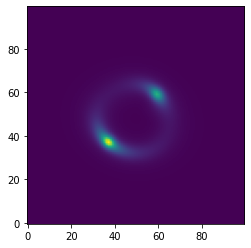

In [120]:
lens_source_class=Lens_Source_model(random_seed=1)

lens_source_class.change_source_light({'amp': None},random_seed=lens_source_class.random_seed)

lens_source_class.change_lens_mass({'theta_E': None},{'gamma1': None},random_seed=lens_source_class.random_seed)


image=lens_source_class.get_lens_picture(lens_mass_list=['SIE','SHEAR'])
plt.imshow(image,origin='lower')

In [105]:
lens_source_class.kwargs_lens_mass

array([{'theta_E': 1.0774223699513465, 'e1': 0.02513914784436317, 'e2': -0.014439353942711472, 'center_y': 0.10259541382450879, 'center_x': 0.004726974328154669},
       {'gamma1': -0.02836810751664014, 'gamma2': -0.008522794695658488, 'ra_0': 0.0, 'dec_0': 0.0}],
      dtype=object)

In [106]:
lens_source_class.kwargs_source_light

array([{'amp': 10.0, 'e1': 0.11688514390186834, 'e2': -0.06713616443535399, 'center_y': -0.07762942105552412, 'center_x': -0.17210122786959164, 'n_sersic': 2.5459879622393946, 'R_sersic': 0.2793848149332354}],
      dtype=object)

In [102]:
lens_source_class.kwargs_lens_mass

array([{'theta_E': 1.1241962271566035, 'e1': 0.02513914784436317, 'e2': -0.014439353942711472, 'center_y': -0.032601082749917985, 'center_x': -0.13392961712604587},
       {'gamma1': 0.0055324097338678305, 'gamma2': -0.020876630244389273, 'ra_0': 0.0, 'dec_0': 0.0}],
      dtype=object)

In [103]:
lens_source_class.kwargs_source_light

array([{'amp': 10.0, 'e1': 0.11688514390186834, 'e2': -0.06713616443535399, 'center_y': -0.03351147183991565, 'center_x': -0.15753217786434479, 'n_sersic': 3.3837173645764542, 'R_sersic': 0.32682911535937686}],
      dtype=object)

In [41]:
lens_source_class.kwargs_noise

{'background_rms': 0, 'exposure_time': None}

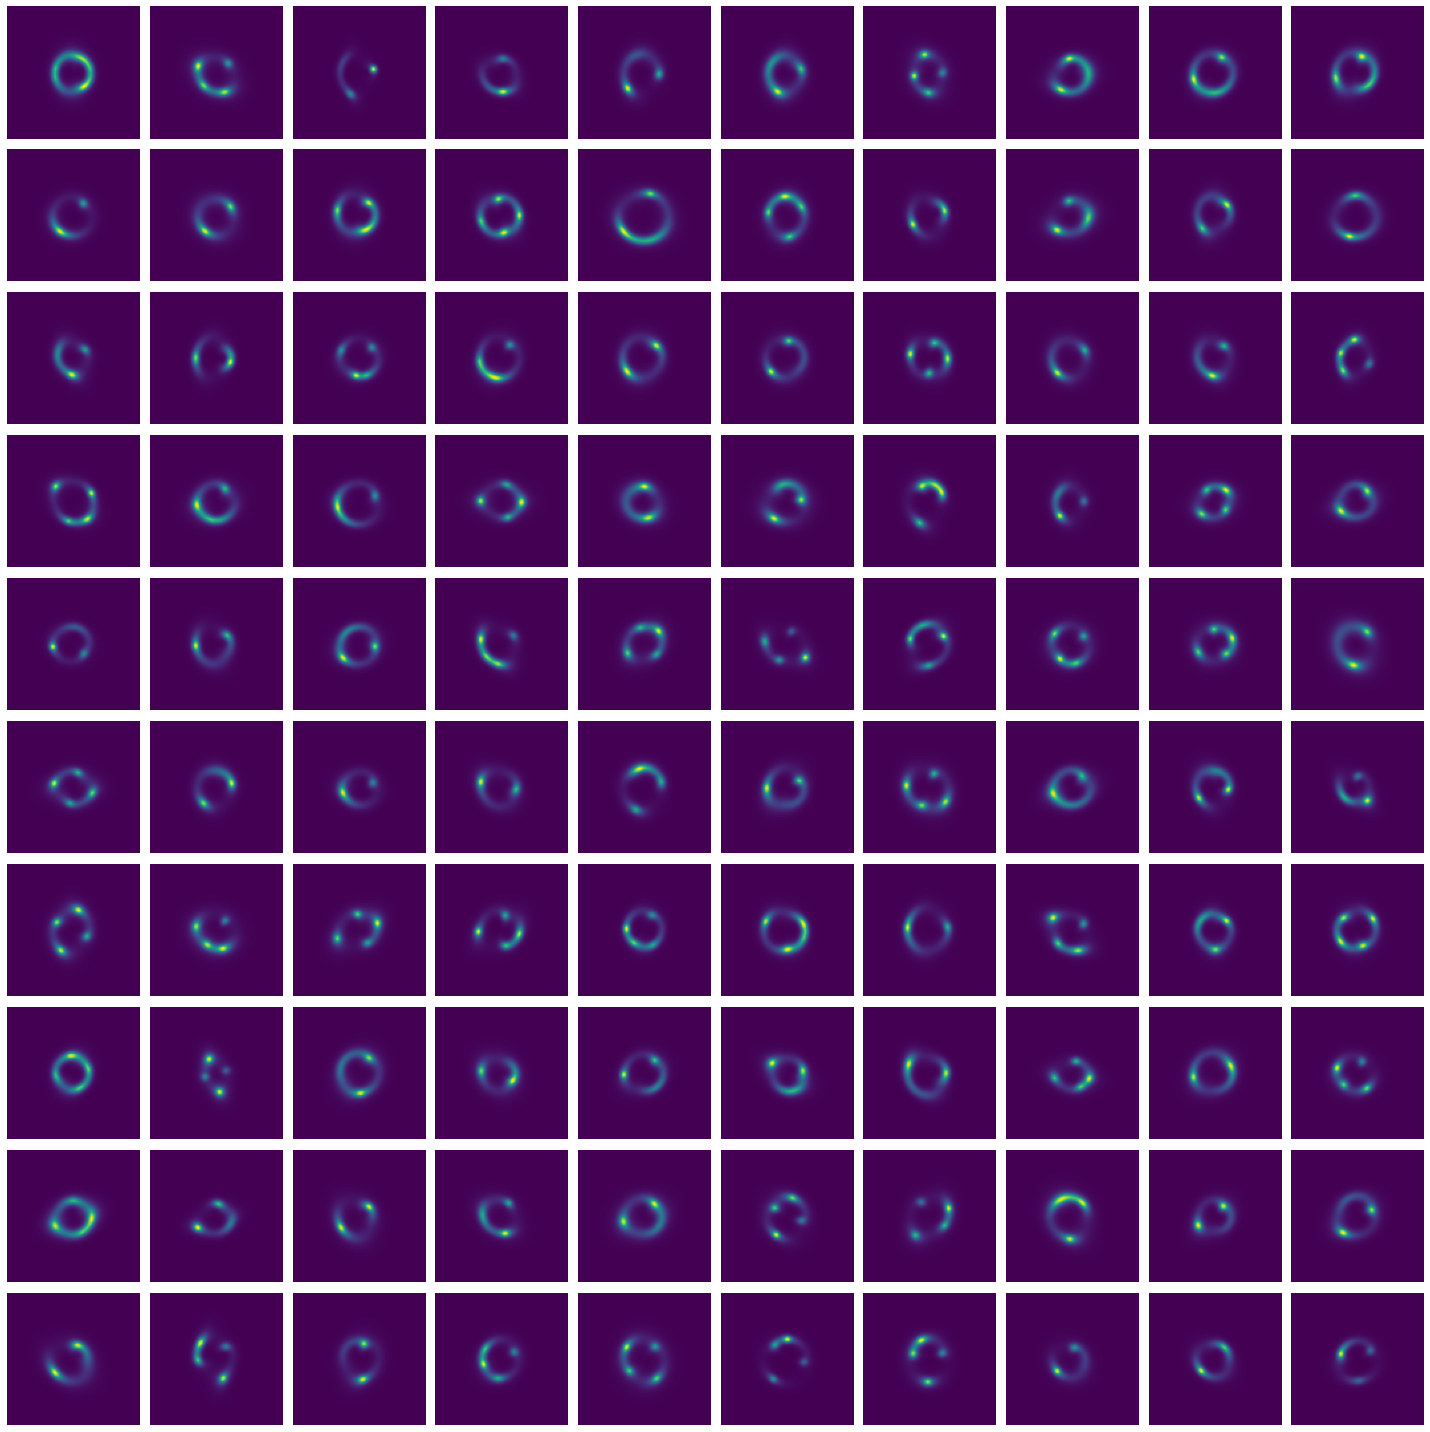

In [33]:
fig,ax=plt.subplots(10,10,figsize=(20,20))

for i in range(10):
  for j in range(10):
    lens_source_class=Lens_Source(random_seed=int(i*10+j))
    lens_source_class.change_source_light({'amp': 5.})
    lens_source_class.change_lens_mass({'theta_E': None},\
                                {'gamma1': None, 'gamma2': None})

    image=lens_source_class.get_lens_picture(lens_mass_list=['SIE','SHEAR'])
    ax[i,j].imshow(image,origin='lower')
    ax[i,j].axis('off')

fig.tight_layout()
plt.show()

In [ ]:
print({'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0}.keys())
print({'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0}.keys())
print({'amp': 10.0,'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}.keys())

dict_keys(['theta_E', 'e1', 'e2', 'center_x', 'center_y'])
dict_keys(['gamma1', 'gamma2', 'ra_0', 'dec_0'])
dict_keys(['amp', 'R_sersic', 'n_sersic', 'center_x', 'center_y', 'e1', 'e2'])


In [ ]:
all_parameters=['theta_E', 'e1', 'e2', 'center_x', 'center_y','gamma1', 'gamma2','R_sersic', 'n_sersic', 'center_x', 'center_y', 'e1', 'e2']

array(['theta_E', 'e1', 'e2', 'center_x', 'center_y'], dtype='<U8')

In [ ]:
#lens_source_class=Lens_Source(random_seed=int(np.abs(np.random.normal(scale=100))))
lens_source_class.change_source_light({'amp': 5.},arbitrary_kwargs_percentile=0.5)

lens_source_class.change_lens_mass({SIE_extremes.iloc[i].name: SIE_extremes.iloc[i,j]},\
                                {'gamma1': None, 'gamma2': None},arbitrary_kwargs_percentile=0.5)
image=lens_source_class.get_lens_picture(lens_mass_list=['SIE','SHEAR'])
datetime.datetime.now()

get_LensImage 0:00:00.027458
kwargs lens 0:00:00.000108
kwargs source 0:00:00.000122
2021-07-26 18:12:31.577713


datetime.datetime(2021, 7, 26, 18, 12, 32, 267520)

In [ ]:
lens_source_class.kwargs_lens_mass

array([], dtype=float64)

100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


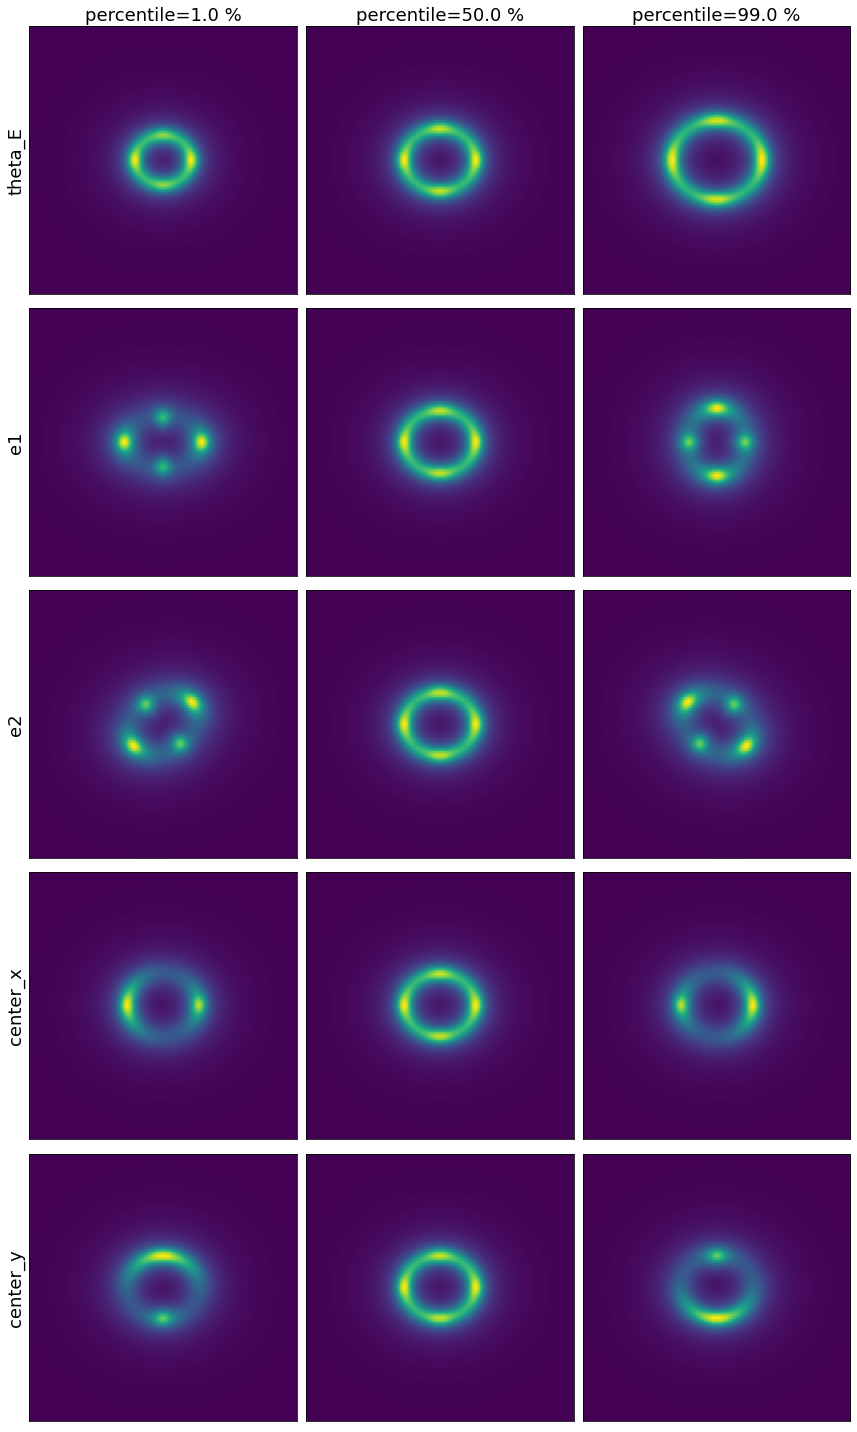

In [ ]:
SIE_extremes=pd.DataFrame(index=['theta_E', 'e1', 'e2', 'center_x', 'center_y'],columns=['0.01','0.5','0.99'])
percentiles=[0.01,0.5,0.99]
for param_name in tqdm(SIE_extremes.index):
  for j in range(3):
    SIE_extremes.loc[param_name].iloc[j]=lens_source_class.init_arg(param_name,'SIE',percentiles[j])

fig,ax=plt.subplots(len(SIE_extremes.index),3,figsize=(12,20))
lens_source_class=Lens_Source(random_seed=int(np.abs(np.random.normal(scale=100))))
lens_source_class.change_source_light({'amp': 5.},arbitrary_kwargs_percentile=0.5)

for i in tqdm(range(len(SIE_extremes.index))):
  for j in range(3):
    lens_source_class.change_lens_mass({SIE_extremes.iloc[i].name: SIE_extremes.iloc[i,j]},\
                                {'gamma1': None, 'gamma2': None},arbitrary_kwargs_percentile=0.5)

    image=lens_source_class.get_lens_picture(lens_mass_list=['SIE','SHEAR'])
    ax[i,j].imshow(image,origin='lower')
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])

for i in range(len(SIE_extremes.index)):
  ax[i,0].set_ylabel(SIE_extremes.index[i], fontsize=FS)

for j in range(3):
        ax[0,j].set_title('percentile={:.1f} %'.format(percentiles[j]*100), fontsize=FS)

fig.tight_layout()
plt.show()

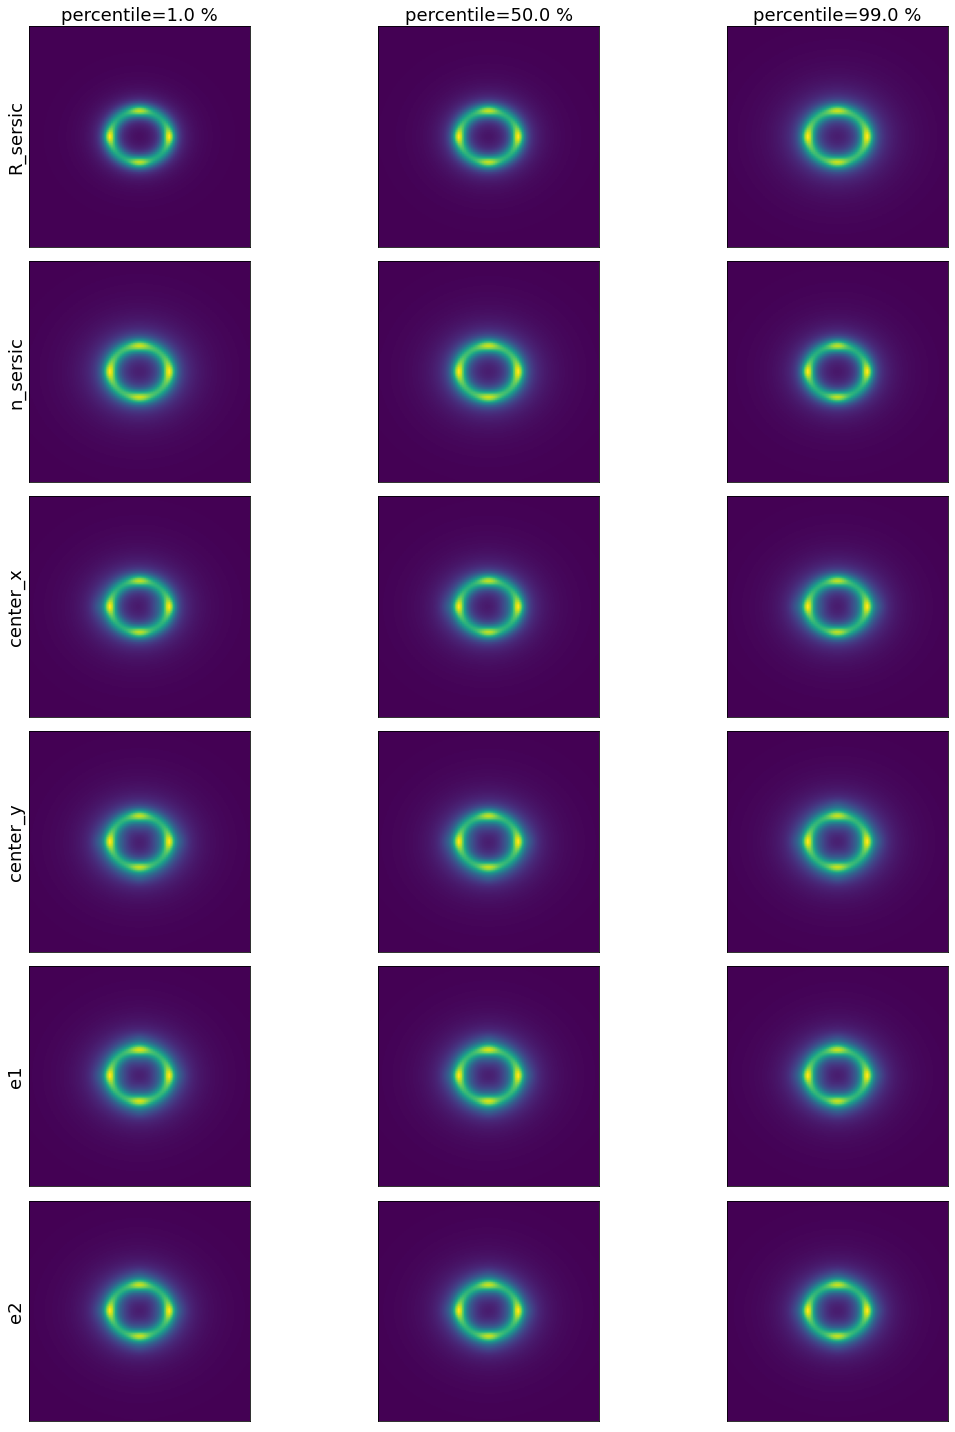

In [ ]:
Sersic_extremes=pd.DataFrame(index=['R_sersic', 'n_sersic', 'center_x', 'center_y', 'e1', 'e2'],columns=['0.01','0.5','0.99'])
percentiles=[0.01,0.5,0.99]

for param_name in Sersic_extremes.index:
  for j in range(3):
    Sersic_extremes.loc[param_name].iloc[j]=lens_source_class.init_arg(param_name,'Sersic',percentiles[j])

fig,ax=plt.subplots(len(Sersic_extremes.index),3,figsize=(16,20))

lens_source_class=Lens_Source(random_seed=int(np.abs(np.random.normal(scale=100))))
lens_source_class.change_lens_mass({'theta_E':None},\
                                {'gamma1': None, 'gamma2': None},arbitrary_kwargs_percentile=0.5)

for i in range(len(Sersic_extremes.index)):
  for j in range(3):
    lens_source_class.change_source_light({Sersic_extremes.iloc[i].name: Sersic_extremes.iloc[i,j]},arbitrary_kwargs_percentile=0.5)

    image=lens_source_class.get_lens_picture()
    ax[i,j].imshow(image,origin='lower')
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])

for i in range(len(Sersic_extremes.index)):
  ax[i,0].set_ylabel(Sersic_extremes.index[i], fontsize=FS)

for j in range(3):
        ax[0,j].set_title('percentile={:.1f} %'.format(percentiles[j]*100), fontsize=FS)

fig.tight_layout()
plt.show()

# GRF class test

In [242]:


#Father class. Descendants are defined by how we define Power spectrum amplitude.
#By potential variance, by deflection variance or by the PS amplitude itself
class GRF_perturbed_lens:
  #Here I fix parameters of the power spectrum, pixel grid, source light, lens light and lens mass
  def __init__(self,Variance=0,Power_slope=1,kwargs_source_light_array=None,kwargs_lens_mass_array=None,\
                 SNR=None,exposure_time=None,kwargs_psf=None,kwargs_pixel=None,random_seed=None):

    self.Lens_Source_model=Lens_Source_model(kwargs_source_light_array,kwargs_lens_mass_array,SNR,\
                                                               exposure_time,kwargs_psf,kwargs_pixel,random_seed)

    #Power spectrum of the potential is PS=A*k^(-beta)
    if np.isin(np.array([Power_slope,Variance]).dtype,['float64','int64']):
      self.Variance=Variance
      self.beta=Power_slope
    else:
      raise ValueError('Wrong arguments data types. npix,pix_scl,beta,Variance,generation_seed should be numbers, so either int or float')

    #Initialize the values. They will be changed further
    self.PS_Amplitude=Variance
    #Adjust power spectrum and kwargs_lens_mass according to Variance and Power slope
    self.Change_Power_Spectrum(Variance=self.Variance,Power_slope=self.beta)



  #sum(P(k) * dk_x * dk_y)=variance is different for potential and deflection
  def Change_Power_Spectrum(self,Variance=None,Power_slope=None):
      if Variance is not None:
        self.Variance=Variance
      if Power_slope is not None:
        self.beta=Power_slope

  #Get LensImage class with all the models and observational parameters set
  def get_LensImage(self,source_light_list=None,lens_mass_list=None):
      return self.Lens_Source_model.get_LensImage(source_light_list,lens_mass_list)

  #Get npix*npix picture for a given lens parameters
  def get_lens_picture(self,source_light_list=None,lens_mass_list=None,picture_type='model',include_GRF=True):
      if include_GRF:
          lens_mass_list_wo_GRF=np.delete(lens_mass_list,np.where(np.array(lens_mass_list)=='PIXELATED')[0])
          return self.Lens_Source_model.get_lens_picture(source_light_list=source_light_list,lens_mass_list=lens_mass_list_wo_GRF,picture_type=picture_type)
      else:
          return self.Lens_Source_model.get_lens_picture(source_light_list=source_light_list,lens_mass_list=lens_mass_list,picture_type=picture_type)


  def get_GRF_potential(self):

    npix=self.Lens_Source_model.kwargs_pixel['nx']
    pix_scl=self.Lens_Source_model.kwargs_pixel['transform_pix2angle'][0,0]
    #2*pi*number_pix*pix_scale
    box_length = 2 * np.pi * npix * pix_scl

    return pbox.PowerBox(N=npix, dim=2, pk=(lambda k: self.PS_Amplitude * k**(-self.beta)), boxlength=box_length, seed=self.Lens_Source_model.random_seed).delta_x()

  def get_total_potential(self,include_GRF=True):
    pixel_grid=PixelGrid(**self.Lens_Source_model.kwargs_pixel)
    xgrid, ygrid = pixel_grid.pixel_coordinates

    if include_GRF:
       lens_mass_model = LensModel(self.Lens_Source_model.lens_mass_model_list)
       return lens_mass_model.potential(xgrid, ygrid, self.Lens_Source_model.kwargs_lens_mass)
    else:
       lens_mass_model = LensModel(self.Lens_Source_model.lens_mass_model_list[:-1])
       return lens_mass_model.potential(xgrid, ygrid, self.Lens_Source_model.kwargs_lens_mass[:-1])

class Deflection_based_GRF_perturbed_lens(GRF_perturbed_lens):

    def __init__(self,Variance=0,Power_slope=1,kwargs_source_light_array=None,kwargs_lens_mass_array=None,\
                 SNR=None,exposure_time=None,kwargs_psf=None,kwargs_pixel=None,random_seed=None):


      super().__init__(Variance,Power_slope,kwargs_source_light_array,kwargs_lens_mass_array,SNR,\
                                                               exposure_time,kwargs_psf,kwargs_pixel,random_seed)

      self.Amplitude_type='deflection variance'
      self.Amplitude_label=r'$\sigma^2_{\delta \alpha}$'
      self.Amplitude_fraction_label=r'$\frac{\sigma^2_{\delta \alpha }}{\sigma^2_{\alpha}}$'

    def Change_Power_Spectrum(self,Variance=None,Power_slope=None):
      super().Change_Power_Spectrum(Variance,Power_slope)

      #Renew power spectrum amplitude
      npix=self.Lens_Source_model.kwargs_pixel['nx']
      pix_scl=self.Lens_Source_model.kwargs_pixel['transform_pix2angle'][0,0]
      #2*pi*number_pix*pix_scale
      box_length = 2 * np.pi * npix * pix_scl

      #deflection is gradient of potential, so the spectrum gains additional (2πk)^2 from the exp(i2πkx)
      deflection_field=pbox.PowerBox(N=npix, dim=2, pk=(lambda k: (2*np.pi*k)**2*k**(-self.beta)), boxlength=box_length, seed=self.Lens_Source_model.random_seed).delta_x()
      self.PS_Amplitude=self.Variance/deflection_field.var()

      #Renew GRF potential map
      old_kwargs_lenses=self.Lens_Source_model.kwargs_lens_mass
      new_kwargs_lenses=np.append(old_kwargs_lenses,{'psi_grid':self.get_GRF_potential()})
      self.Lens_Source_model.change_lens_mass(*new_kwargs_lenses)

class Potential_based_GRF_perturbed_lens(GRF_perturbed_lens):

    def __init__(self,Variance=0,Power_slope=1,kwargs_source_light_array=None,kwargs_lens_mass_array=None,\
                 SNR=None,exposure_time=None,kwargs_psf=None,kwargs_pixel=None,random_seed=None):


      super().__init__(Variance,Power_slope,kwargs_source_light_array,kwargs_lens_mass_array,SNR,\
                                                               exposure_time,kwargs_psf,kwargs_pixel,random_seed)

      self.Amplitude_type='potential variance'
      self.Amplitude_label=r'$\sigma^2_{\delta \psi}$'
      self.Amplitude_fraction_label=r'$\frac{\sigma^2_{\delta \psi }}{\sigma^2_{\psi}}$'

    def Change_Power_Spectrum(self,Variance=None,Power_slope=None):
      super().Change_Power_Spectrum(Variance,Power_slope)

      #Renew power spectrum amplitude
      npix=self.Lens_Source_model.kwargs_pixel['nx']
      pix_scl=self.Lens_Source_model.kwargs_pixel['transform_pix2angle'][0,0]
      #2*pi*number_pix*pix_scale
      box_length = 2 * np.pi * npix * pix_scl

      #Actually, the amplitude can be calculated from relation sum(P(k) * dk_x * dk_y)=variance
      #But here we just rescale the field from A=1 to not mess with it
      potential_field=pbox.PowerBox(N=npix, dim=2, pk=(lambda k: k**(-self.beta)), boxlength=box_length, seed=self.Lens_Source_model.random_seed).delta_x()
      self.PS_Amplitude=self.Variance/potential_field.var()

      #Renew GRF potential map
      old_kwargs_lenses=self.Lens_Source_model.kwargs_lens_mass
      new_kwargs_lenses=np.append(old_kwargs_lenses,{'psi_grid':self.get_GRF_potential()})
      self.Lens_Source_model.change_lens_mass(*new_kwargs_lenses)

class PS_Amplitude_based_GRF_perturbed_lens(GRF_perturbed_lens):

    def __init__(self,Variance=0,Power_slope=1,kwargs_source_light_array=None,kwargs_lens_mass_array=None,\
                 SNR=None,exposure_time=None,kwargs_psf=None,kwargs_pixel=None,random_seed=None):


      super().__init__(Variance,Power_slope,kwargs_source_light_array,kwargs_lens_mass_array,SNR,\
                                                               exposure_time,kwargs_psf,kwargs_pixel,random_seed)

      self.Amplitude_type='spectral amplitude'
      self.Amplitude_label='A'
      self.Amplitude_fraction_label='A'

    def Change_Power_Spectrum(self,Variance=None,Power_slope=None):
      super().Change_Power_Spectrum(Variance,Power_slope)

      #Renew power spectrum amplitude
      self.PS_Amplitude=self.Variance


      #Renew GRF potential map
      old_kwargs_lenses=self.Lens_Source_model.kwargs_lens_mass
      new_kwargs_lenses=np.append(old_kwargs_lenses,{'psi_grid':self.get_GRF_potential()})
      self.Lens_Source_model.change_lens_mass(*new_kwargs_lenses)


# Lens model class

In [ ]:
#Basic imports
import numpy as np
import scipy.stats as stats
from copy import deepcopy

#Jaxtronomy
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage


# In this script we introduce a class that handles kwargs of Source and Lens
# You can add lens mass instances or Source light instances using "change_lens_mass","change_source_mass"
#You can add kwargs in form of {'R_sersic':1,'n_sersic':None}. All the required arguments that were not defined or set
#to "None" would be sampled from their prior distributions

#Random generation seed
default_random_seed=42
np.random.seed(default_random_seed)


# Default strong lensing layout
npix=100
pix_scl=0.08 #arcsec/pix

default_kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': (1-npix)*pix_scl / 2, 'dec_at_xy_0': (1-npix)*pix_scl / 2,
                'transform_pix2angle': pix_scl * np.eye(2)}

default_kwargs_psf={'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
default_exposure_time=2028
default_SNR=100

default_source_light_model_list=['SERSIC_ELLIPSE']
default_lens_mass_model_list=['SIE','SHEAR']
default_lens_light_model_list=[]

# These functions sample parameters from their prior distribution https://arxiv.org/pdf/2010.13787.pdf
#Lenses are either SIE, external Shear
class Lens_Source_model:

    #One can provide arguments for source-lens setup
    #Arguments not provided will be sampled from prior distribution
    #One can also pick argument value in units of their distribution's sigmas
    def __init__(self, kwargs_source_light_array=None, kwargs_lens_mass_array=None, \
                 SNR=None, exposure_time=None, kwargs_psf=None, \
                 kwargs_pixel=None, random_seed=None):

        if SNR is None:
            SNR = default_SNR

        if exposure_time is None:
            exposure_time=default_exposure_time

        if kwargs_psf is None:
            kwargs_psf = default_kwargs_psf

        if kwargs_pixel is None:
            kwargs_pixel=default_kwargs_pixel

        if random_seed is None:
            random_seed=default_random_seed


        self.random_seed=deepcopy(random_seed)
        self.kwargs_pixel=deepcopy(kwargs_pixel)
        self.kwargs_psf=deepcopy(kwargs_psf)
        self.SNR=SNR

        #Sersic elliptical light
        self.Sersic_arg_names=np.array(['amp','R_sersic','n_sersic','center_x','center_y','e1','e2'])
        #SIE, SHEAR, PIXELATED
        self.SIE_arg_names=np.array(['theta_E','e1','e2','center_x','center_y'])
        self.Shear_arg_names=np.array(['gamma1','gamma2','ra_0','dec_0'])
        self.Pixelated_arg_names=np.array(['psi_grid','x_coords','y_coords'])

        self.source_light_model_list=np.array([])
        self.kwargs_source_light=np.array([])

        self.lens_light_model_list=np.array([])
        self.kwargs_lens_light=np.array([])

        self.lens_mass_model_list=np.array([])
        self.kwargs_lens_mass=np.array([])

        if kwargs_source_light_array is not None:
          self.change_source_light(kwargs_source_light_array)

        if kwargs_lens_mass_array is not None:
          self.change_lens_mass(kwargs_lens_mass_array)


        #To use peakSNR draw clean image and get peak intensity
        self.kwargs_noise={'background_rms': 0, 'exposure_time': exposure_time}
        self.renew_noise_from_SNR()

    #Draw image, find peak intensity, define sigma_bkg from peakSNR
    def renew_noise_from_SNR(self):
        Peak_signal=np.abs(self.get_lens_picture(picture_type='model')).max()
        sigma_bkd = Peak_signal/self.SNR
        self.kwargs_noise = {'background_rms': sigma_bkd, 'exposure_time': self.kwargs_noise['exposure_time']}



    #Pass dictionaries of kwargs. If a model require a parameter that is not set in the dict
    #Then use the prior distribution of the parameter to either take a quantile or randomly sample value
    def change_lens_mass(self,*kwargs_of_lenses,arbitrary_kwargs_percentile=None,random_seed=None):

        self.lens_mass_model_list=np.array([])
        self.kwargs_lens_mass=np.array([])

        #Consequently parse all the kwargs given
        for i,kwargs in enumerate(kwargs_of_lenses):

            if len(kwargs.keys())==0:
              continue

            #These two models have prior distributions, so we need to
            #so we can sample arguments that were set to None or not defined at all
            if np.isin(list(kwargs.keys()),self.SIE_arg_names).all():



                #Values that are not defined
                arbitrary_kwargs=set(self.SIE_arg_names).difference(set(kwargs.keys()))
                None_kwargs=np.array(list(kwargs.keys()))[np.where(np.array(list(kwargs.values()))==None)]
                arbitrary_kwargs.update(set(None_kwargs))
                #Defined and None statements here
                model_kwargs=deepcopy(kwargs)


                #If we need ellipticities sample them from radial coords
                if len(arbitrary_kwargs.intersection({'e1','e2'}))>0:
                  e1,e2=self.init_ellipticities('SIE',arbitrary_kwargs_percentile,random_seed)
                  model_kwargs.update({'e1':e1,'e2':e2})
                  #Ellipticities are not arbitrary now
                  arbitrary_kwargs=arbitrary_kwargs-{'e1','e2'}

                #Define all the other statements
                for argname in arbitrary_kwargs:
                  model_kwargs.update({argname:self.init_arg(argname,'SIE',arbitrary_kwargs_percentile,random_seed)})

                #Add new lens instance
                self.lens_mass_model_list=np.append(self.lens_mass_model_list,'SIE')
                self.kwargs_lens_mass=np.append(self.kwargs_lens_mass,model_kwargs)

            elif np.isin(list(kwargs.keys()),self.Shear_arg_names).all():

                #Values that are not defined
                arbitrary_kwargs=set(self.Shear_arg_names).difference(set(kwargs.keys()))
                model_kwargs=deepcopy(kwargs)

                if len(arbitrary_kwargs.intersection({'gamma1','gamma2'}))>0:
                  #Then we sample from prior distribution
                  #Transofrm from radial coordinates to cartesian
                  shear_modulus=self.init_arg('shear_modulus','SHEAR',arbitrary_kwargs_percentile,random_seed)
                  shear_angle=self.init_arg('shear_angle','SHEAR',arbitrary_kwargs_percentile,random_seed)
                  model_kwargs.update({'gamma1':shear_modulus*np.cos(2*shear_angle),'gamma2':shear_modulus*np.sin(2*shear_angle)})
                if len(arbitrary_kwargs.intersection({'ra_0','dec_0'}))>0:
                  model_kwargs.update({'ra_0': 0.0, 'dec_0': 0.0})

                self.lens_mass_model_list=np.append(self.lens_mass_model_list,'SHEAR')
                self.kwargs_lens_mass=np.append(self.kwargs_lens_mass,model_kwargs)



            #For pixelated 'psi_grid' is required. Coordinate grid is built from observation conditions
            elif np.isin(list(kwargs.keys()),self.Pixelated_arg_names).all():

                #Values that are not defined
                arbitrary_kwargs=set(self.Pixelated_arg_names).difference(set(kwargs.keys()))
                #Add pix_grid
                model_kwargs=deepcopy(kwargs)
                if 'psi_grid' in arbitrary_kwargs:
                    npix=self.kwargs_pixel['nx']
                    model_kwargs.update({'psi_grid': np.zeros((npix,npix))})

                if len(arbitrary_kwargs.intersection({'x_coords','y_coords'}))>0:
                  #Add coordianated grid
                  pixel_grid = PixelGrid(**self.kwargs_pixel)
                  xgrid, ygrid = pixel_grid.pixel_coordinates
                  x_coords = xgrid[0, :]
                  y_coords = ygrid[:, 0]
                  #Update class fields
                  model_kwargs.update({'x_coords': x_coords, 'y_coords': y_coords})

                self.kwargs_lens_mass=np.append(self.kwargs_lens_mass,model_kwargs)
                #Add new lens instance
                self.lens_mass_model_list=np.append(self.lens_mass_model_list,'PIXELATED')

            else:
              raise ValueError('Wrong arguments in kwargs dict number {} '.format(i))

        #Renew noise for the new setup
        self.renew_noise_from_SNR()



    #Pass dictionaries of kwargs. If a model require a parameter that is not set in the dict
    #Then use the prior distribution of the parameter to either take a quantile or randomly sample value
    def change_source_light(self,*kwargs_of_sources,arbitrary_kwargs_percentile=None,random_seed=None):

        self.lens_light_model_list=np.array([])
        self.kwargs_lens_light=np.array([])

        #Consequently parse all the kwargs given
        for i,kwargs in enumerate(kwargs_of_sources):
            if len(kwargs.keys())==0:
              continue

            if np.isin(list(kwargs.keys()),self.Sersic_arg_names).all():
              self.source_light_model_list=np.append(self.source_light_model_list,'SERSIC_ELLIPSE')
              arbitrary_kwargs=set(self.Sersic_arg_names).difference(set(kwargs.keys()))
              None_kwargs=np.array(list(kwargs.keys()))[np.where(np.array(list(kwargs.values()))==None)]
              arbitrary_kwargs.update(set(None_kwargs))

              #Defined and None statements here
              model_kwargs=deepcopy(kwargs)

              #If we need ellipticities sample them from radial coords
              if len(arbitrary_kwargs.intersection({'e1','e2'}))>0:
                e1,e2=self.init_ellipticities('SERSIC',arbitrary_kwargs_percentile,random_seed)
                model_kwargs.update({'e1':e1,'e2':e2})
                #Ellipticities are not arbitrary now
                arbitrary_kwargs=arbitrary_kwargs-{'e1','e2'}

              for argname in arbitrary_kwargs:
                model_kwargs.update({argname:self.init_arg(argname,'SERSIC',arbitrary_kwargs_percentile,random_seed)})

              self.kwargs_source_light=np.append(self.kwargs_source_light,model_kwargs)
            else:
              raise ValueError('Wrong arguments in kwargs dict number {} '.format(i))


        #Renew noise for the new setup
        self.renew_noise_from_SNR()

    def init_ellipticities(self,model_type='SIE',arbitrary_kwargs_percentile=None,random_seed=None):

        if isinstance(model_type,str):
            model_type=model_type.lower()
        else:
            raise ValueError('Your model type should be string from allowed ones: \n'\
                 +' \n'.join(['SIE','SERSIC']))

        if model_type=='sie':
            axis_ratio=self.init_arg('lens_q','sie',arbitrary_kwargs_percentile,random_seed)
            angle=self.init_arg('lens_angle','sie',arbitrary_kwargs_percentile,random_seed)
        elif model_type=='sersic':
            axis_ratio=self.init_arg('source_q','sersic',arbitrary_kwargs_percentile,random_seed)
            angle=self.init_arg('source_angle','sersic',arbitrary_kwargs_percentile,random_seed)

        #Transform radial representation to cartesian
        e1=(1-axis_ratio)/(1+axis_ratio)*np.cos(2*angle)
        e2=(1-axis_ratio)/(1+axis_ratio)*np.sin(2*angle)
        return e1,e2


    #Either return quantile of prior distribution corresponding to the parameter
    #Or sample value from the prior distribution
    def init_arg(self,argument_name,model_type='SIE',percentile=None,random_seed=None):

        if isinstance(model_type,str):
            model_type=model_type.lower()
        else:
            raise ValueError('Your model type should be string from allowed ones: \n'\
                 +' \n'.join(['SIE','SHEAR','SERSIC']))

        #Priors from Park et al 2021
        if model_type=='sie':
          Prior_distributions={'theta_e':{'distr':'norm','loc':1.1,'scale':0.1},\
                               'center_x':{'distr':'norm','loc':0.,'scale':0.07},\
                               'center_y':{'distr':'norm','loc':0.,'scale':0.07},\
                               'lens_q':{'distr':'norm','loc':0.7,'scale':0.15},\
                               'lens_angle':{'distr':'uniform','loc':-np.pi/2,'scale':np.pi}}

        elif model_type=='shear':
          Prior_distributions={'shear_modulus':{'distr':'uniform','loc':0,'scale':0.05},\
                               'shear_angle':{'distr':'uniform','loc':-np.pi/2,'scale':np.pi}}

        elif model_type=='sersic':
          Prior_distributions={'amp':{'distr':'const','value':10.},\
                               'r_sersic':{'distr':'norm','loc':0.35,'scale':0.05},\
                               'n_sersic':{'distr':'norm','loc':3,'scale':0.5},\
                               'center_x':{'distr':'uniform','loc':-0.2,'scale':0.2},\
                               'center_y':{'distr':'uniform','loc':-0.2,'scale':0.2},\
                               'source_q':{'distr':'norm','loc':0.6,'scale':0.1},\
                               'source_angle':{'distr':'uniform','loc':-np.pi/2,'scale':np.pi}}


        #Priors from Wagner-Carena et al. 2021
        '''
        if model_type=='sie':
          Prior_distributions={'theta_e':{'distr':'lognorm','scale':np.exp(0.),'s':0.1},\
                               'center_x':{'distr':'norm','loc':0.,'scale':0.102},\
                               'center_y':{'distr':'norm','loc':0.,'scale':0.102},\
                               'e1':{'distr':'norm','loc':0.,'scale':0.2},\
                               'e2':{'distr':'norm','loc':0.,'scale':0.2}}

        elif model_type=='shear':
          Prior_distributions={'shear_modulus':{'distr':'lognorm','scale':np.exp(-2.73),'s':1.05},\
                               'shear_angle':{'distr':'uniform','loc':-np.pi/2,'scale':np.pi}}

        elif model_type=='sersic':
          Prior_distributions={'amp':{'distr':'const','value':10.},\
                               'r_sersic':{'distr':'lognorm','loc':np.exp(-0.7),'s':0.4},\
                               'n_sersic':{'distr':'lognorm','loc':np.exp(0.7),'s':0.4},\
                               'center_x':{'distr':'gennorm','loc':0.,'scale':0.4,'beta':10.},\
                               'center_y':{'distr':'gennorm','loc':0.,'scale':0.4,'beta':10.},\
                               'e1':{'distr':'norm','loc':0.,'scale':0.2},\
                               'e2':{'distr':'norm','loc':0.,'scale':0.2}}
        '''

        if isinstance(argument_name,str) and np.isin(argument_name.lower(),list(Prior_distributions.keys())).item():
            argument_name=argument_name.lower()
        else:
            raise ValueError('Your argument name should be string from allowed ones: \n'\
                 +' \n'.join(list(Prior_distributions.keys())))

        distr_name=Prior_distributions[argument_name]['distr']
        params=deepcopy(Prior_distributions[argument_name])
        params.pop('distr')

        if distr_name=='uniform':
            distr_func=stats.uniform(**params)
        elif distr_name=='norm':
            distr_func=stats.norm(**params)
        elif distr_name=='lognorm':
            distr_func=stats.lognorm(**params)
        elif distr_name=='gennorm':
            distr_func=stats.gennorm(**params)
        elif distr_name=='const':
            #Its always one and the same value
            return params['value']
        else:
            raise ValueError("Error in prior distribution names. Pick one from: 'uniform','norm','lognormal','gennorm','const'" )


        #Return quantile or sample from distribution
        if isinstance(percentile,float):
            #Cut percentile to [0,1]
            percentile=np.maximum(0,percentile)
            percentile=np.minimum(1,percentile)
            return distr_func.ppf(percentile)
        else:
            if random_seed is None:
              return distr_func.rvs()
            else:
              distr_func.random_state=random_seed
              return distr_func.rvs()

    #Get LensImage class with all the models and observational parameters set
    def get_LensImage(self,source_light_list=None,lens_mass_list=None):

        if source_light_list is None:
            source_light_list=self.source_light_model_list

        if lens_mass_list is None:
            lens_mass_list=self.lens_mass_model_list

        return LensImage(data_class=PixelGrid(**self.kwargs_pixel),
                    psf_class=PSF(**self.kwargs_psf),
                    noise_class=Noise(self.kwargs_pixel['nx'], self.kwargs_pixel['ny'], **self.kwargs_noise),
                    source_model_class=LightModel(source_light_list),
                    lens_model_class=LensModel(lens_mass_list),
                    lens_light_model_class=LightModel(self.lens_light_model_list),
                    kwargs_numerics={'supersampling_factor': 1})



    #Get npix*npix picture for a given lens parameters
    def get_lens_picture(self,source_light_list=None,lens_mass_list=None,picture_type='model'):


        if source_light_list is None:
            source_light_list_present=self.source_light_model_list
        else:
            source_light_list_present=np.intersect1d(self.source_light_model_list,source_light_list)


        if lens_mass_list is None:
            lens_mass_list_present=self.lens_mass_model_list
        else:
            lens_mass_list_present=np.intersect1d(self.lens_mass_model_list,lens_mass_list)




        lens_image=self.get_LensImage(source_light_list_present,lens_mass_list_present)
        lens_mass_model_list=deepcopy(self.lens_mass_model_list)


        kwargs_lens_mass=np.array([])
        for mass_model_name in lens_mass_list_present:
            #Append mass model if it is present
            index=np.where(lens_mass_model_list==mass_model_name)[0][0]
            mass_model=self.kwargs_lens_mass[index]
            #To exclude it out of the search
            lens_mass_model_list[index]=np.nan
            kwargs_lens_mass=np.append(kwargs_lens_mass,mass_model)



        kwargs_source_light=np.array([])
        for source_model_name in source_light_list_present:
            #Append light model if it is present
            light_model=self.kwargs_source_light[np.where(self.source_light_model_list==source_model_name)[0]]
            kwargs_source_light=np.append(kwargs_source_light,light_model)

        if picture_type=='model':
            return lens_image.model(kwargs_lens=list(kwargs_lens_mass),
                          kwargs_source=list(kwargs_source_light),
                          kwargs_lens_light=self.kwargs_lens_light)

        elif picture_type=='simulation':
            return lens_image.simulation(compute_true_noise_map=True,
                          kwargs_lens=list(kwargs_lens_mass),
                          kwargs_source=list(kwargs_source_light),
                          kwargs_lens_light=self.kwargs_lens_light)

        else:
            raise ValueError('Wrong picture_type. Pick one of: \n model, \n simulation')


#GRF class

In [ ]:
# Basic imports
import numpy as np
from copy import deepcopy

# Basic JAX
from jax.config import config
config.update("jax_enable_x64", True)

# jaxtronomy imports
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.GaussianRandomField import Lens_Source_model

#GRF generator
import powerbox as pbox

# Universal font size
FS = 18


#Father class. Descendants are defined by how we define Power spectrum amplitude.
#By potential variance, by deflection variance or by the PS amplitude itself
class GRF_perturbed_lens:
  #Here I fix parameters of the power spectrum, pixel grid, source light, lens light and lens mass
  def __init__(self,Variance=0,Power_slope=1,kwargs_source_light_array=None,kwargs_lens_mass_array=None,\
                 SNR=None,exposure_time=None,kwargs_psf=None,kwargs_pixel=None,random_seed=None):

    self.Lens_Source_model=Lens_Source_model.Lens_Source_model(kwargs_source_light_array,kwargs_lens_mass_array,SNR,\
                                                               exposure_time,kwargs_psf,kwargs_pixel,random_seed)

    #Power spectrum of the potential is PS=A*k^(-beta)
    if np.isin(np.array([Power_slope,Variance]).dtype,['float64','int64']):
      self.Variance=Variance
      self.beta=Power_slope
    else:
      raise ValueError('Wrong arguments data types. npix,pix_scl,beta,Variance,generation_seed should be numbers, so either int or float')

    #Initialize the values. They will be changed further
    self.PS_Amplitude=Variance
    #Adjust power spectrum and kwargs_lens_mass according to Variance and Power slope
    self.Change_Power_Spectrum(Variance=self.Variance,Power_slope=self.beta)



  #sum(P(k) * dk_x * dk_y)=variance is different for potential and deflection
  def Change_Power_Spectrum(self,Variance=None,Power_slope=None):
      if Variance is not None:
        self.Variance=Variance
      if Power_slope is not None:
        self.beta=Power_slope

  #Get LensImage class with all the models and observational parameters set
  def get_LensImage(self,source_light_list=None,lens_mass_list=None):
      return self.Lens_Source_model.get_LensImage(source_light_list,lens_mass_list)

  #Get npix*npix picture for a given lens parameters
  def get_lens_picture(self,source_light_list=None,lens_mass_list=None,picture_type='model',include_GRF=True):
      if include_GRF:
          lens_mass_list_wo_GRF=np.delete(lens_mass_list,np.where(np.array(lens_mass_list)=='PIXELATED')[0])
          return self.Lens_Source_model.get_lens_picture(source_light_list=source_light_list,lens_mass_list=lens_mass_list_wo_GRF,picture_type=picture_type)
      else:
          return self.Lens_Source_model.get_lens_picture(source_light_list=source_light_list,lens_mass_list=lens_mass_list,picture_type=picture_type)


  def get_GRF_potential(self):

    npix=self.Lens_Source_model.kwargs_pixel['nx']
    pix_scl=self.Lens_Source_model.kwargs_pixel['transform_pix2angle'][0,0]
    #2*pi*number_pix*pix_scale
    box_length = 2 * np.pi * npix * pix_scl

    return pbox.PowerBox(N=npix, dim=2, pk=(lambda k: self.PS_Amplitude * k**(-self.beta)), boxlength=box_length, seed=self.Lens_Source_model.random_seed).delta_x()

  def get_total_potential(self,include_GRF=True):
    pixel_grid=PixelGrid(**self.Lens_Source_model.kwargs_pixel)
    xgrid, ygrid = pixel_grid.pixel_coordinates

    if include_GRF:
       lens_mass_model = LensModel(self.Lens_Source_model.lens_mass_model_list)
       return lens_mass_model.potential(xgrid, ygrid, self.Lens_Source_model.kwargs_lens_mass)
    else:
       lens_mass_model = LensModel(self.Lens_Source_model.lens_mass_model_list[:-1])
       return lens_mass_model.potential(xgrid, ygrid, self.Lens_Source_model.kwargs_lens_mass[:-1])

class Deflection_based_GRF_perturbed_lens(GRF_perturbed_lens):

    def __init__(self,Variance=0,Power_slope=1,kwargs_source_light_array=None,kwargs_lens_mass_array=None,\
                 SNR=None,exposure_time=None,kwargs_psf=None,kwargs_pixel=None,random_seed=None):


      super().__init__(Variance,Power_slope,kwargs_source_light_array,kwargs_lens_mass_array,SNR,\
                                                               exposure_time,kwargs_psf,kwargs_pixel,random_seed)

      self.Amplitude_type='deflection variance'
      self.Amplitude_label=r'$\sigma^2_{\delta \alpha}$'
      self.Amplitude_fraction_label=r'$\frac{\sigma^2_{\delta \alpha }}{\sigma^2_{\alpha}}$'

    def Change_Power_Spectrum(self,Variance=None,Power_slope=None):
      super().Change_Power_Spectrum(Variance,Power_slope)

      #Renew power spectrum amplitude
      npix=self.Lens_Source_model.kwargs_pixel['nx']
      pix_scl=self.Lens_Source_model.kwargs_pixel['transform_pix2angle'][0,0]
      #2*pi*number_pix*pix_scale
      box_length = 2 * np.pi * npix * pix_scl

      #deflection is gradient of potential, so the spectrum gains additional (2πk)^2 from the exp(i2πkx)
      deflection_field=pbox.PowerBox(N=npix, dim=2, pk=(lambda k: (2*np.pi*k)**2*k**(-self.beta)), boxlength=box_length, seed=self.Lens_Source_model.random_seed).delta_x()
      self.PS_Amplitude=self.Variance/deflection_field.var()

      #Renew GRF potential map
      old_kwargs_lenses=self.Lens_Source_model.kwargs_lens_mass
      new_kwargs_lenses=np.append(old_kwargs_lenses,{'psi_grid':self.get_GRF_potential()})
      self.Lens_Source_model.change_lens_mass(*new_kwargs_lenses)

class Potential_based_GRF_perturbed_lens(GRF_perturbed_lens):

    def __init__(self,Variance=0,Power_slope=1,kwargs_source_light_array=None,kwargs_lens_mass_array=None,\
                 SNR=None,exposure_time=None,kwargs_psf=None,kwargs_pixel=None,random_seed=None):


      super().__init__(Variance,Power_slope,kwargs_source_light_array,kwargs_lens_mass_array,SNR,\
                                                               exposure_time,kwargs_psf,kwargs_pixel,random_seed)

      self.Amplitude_type='potential variance'
      self.Amplitude_label=r'$\sigma^2_{\delta \psi}$'
      self.Amplitude_fraction_label=r'$\frac{\sigma^2_{\delta \psi }}{\sigma^2_{\psi}}$'

    def Change_Power_Spectrum(self,Variance=None,Power_slope=None):
      super().Change_Power_Spectrum(Variance,Power_slope)

      #Renew power spectrum amplitude
      npix=self.Lens_Source_model.kwargs_pixel['nx']
      pix_scl=self.Lens_Source_model.kwargs_pixel['transform_pix2angle'][0,0]
      #2*pi*number_pix*pix_scale
      box_length = 2 * np.pi * npix * pix_scl

      #Actually, the amplitude can be calculated from relation sum(P(k) * dk_x * dk_y)=variance
      #But here we just rescale the field from A=1 to not mess with it
      potential_field=pbox.PowerBox(N=npix, dim=2, pk=(lambda k: k**(-self.beta)), boxlength=box_length, seed=self.Lens_Source_model.random_seed).delta_x()
      self.PS_Amplitude=self.Variance/potential_field.var()

      #Renew GRF potential map
      old_kwargs_lenses=self.Lens_Source_model.kwargs_lens_mass
      new_kwargs_lenses=np.append(old_kwargs_lenses,{'psi_grid':self.get_GRF_potential()})
      self.Lens_Source_model.change_lens_mass(*new_kwargs_lenses)

class PS_Amplitude_based_GRF_perturbed_lens(GRF_perturbed_lens):

    def __init__(self,Variance=0,Power_slope=1,kwargs_source_light_array=None,kwargs_lens_mass_array=None,\
                 SNR=None,exposure_time=None,kwargs_psf=None,kwargs_pixel=None,random_seed=None):


      super().__init__(Variance,Power_slope,kwargs_source_light_array,kwargs_lens_mass_array,SNR,\
                                                               exposure_time,kwargs_psf,kwargs_pixel,random_seed)

      self.Amplitude_type='spectral amplitude'
      self.Amplitude_label='A'
      self.Amplitude_fraction_label='A'

    def Change_Power_Spectrum(self,Variance=None,Power_slope=None):
      super().Change_Power_Spectrum(Variance,Power_slope)

      #Renew power spectrum amplitude
      self.PS_Amplitude=self.Variance


      #Renew GRF potential map
      old_kwargs_lenses=self.Lens_Source_model.kwargs_lens_mass
      new_kwargs_lenses=np.append(old_kwargs_lenses,{'psi_grid':self.get_GRF_potential()})
      self.Lens_Source_model.change_lens_mass(*new_kwargs_lenses)


In [ ]:
Sersic_extremes

,0.001,0.5,0.999
R_sersic,0.787102,1.49659,3.93872
n_sersic,2.30427,3.01375,5.45589
center_x,-0.443444,0,0.443444
center_y,-0.443444,0,0.443444
e1,-0.618046,0,0.618046
e2,-0.618046,0,0.618046


In [ ]:
len(SIE_extremes.index)

5

In [ ]:
SIE_extremes.loc['theta_E'].iloc[0]

0.8220151951983891

In [ ]:
SIE_extremes.iloc[0].name

'theta_E'

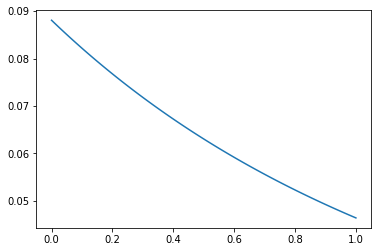

In [ ]:
arr=np.linspace(0,1,100)
plt.plot(arr,stats.lognorm(loc=-2.73,s=1.05).pdf(arr))

In [ ]:
test_arr=np.zeros(1000)
for i in range(1000):
  test_arr[i]=stats.lognorm(scale=np.exp(-2.73),s=1.05).rvs()

In [ ]:
stats.lognorm(scale=np.exp(-2.73),s=1.05).stats()

(array(0.11318292), array(0.02577045))

(array([782., 154.,  29.,  12.,   8.,   6.,   2.,   2.,   3.,   2.]),
 array([1.04095166e-03, 1.53944855e-01, 3.06848759e-01, 4.59752663e-01,
        6.12656566e-01, 7.65560470e-01, 9.18464374e-01, 1.07136828e+00,
        1.22427218e+00, 1.37717608e+00, 1.53007999e+00]),
 <a list of 10 Patch objects>)

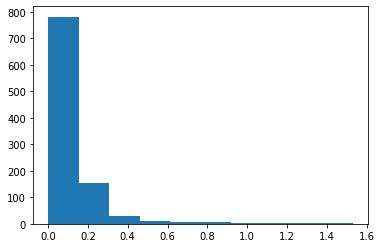

In [ ]:
plt.hist(test_arr)

In [ ]:
light_list=np.array(['SERSIC_ELLIPSE','dasdas','SERSIC_ELLIPSE'])
light_kwargs=np.array([{'a':1},{'r':2},{'f':3}])

In [ ]:
light_kwargs[np.where(light_list=='SERSIC_ELLIPSE')[0]]

array([{'a': 1}, {'f': 3}], dtype=object)

In [ ]:
np.isin({'psi_grid':np.zeros((100,100))}.keys(),np.array(['psi_grid']))

array(False)

In [ ]:
set({'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0}.keys())

{'center_x', 'center_y', 'e1', 'e2', 'theta_E'}

In [ ]:
lens_source_class.lens_mass_model_list

array(['SIE'], dtype='<U32')

In [ ]:
list_mass=np.array(['SIE','SHEAR','PIXELATED'])

In [ ]:
np.where(list_mass==np.array(['SIE','SHEAR']).T)

ValueError: ignored

In [ ]:
set({'gamma_2':2,'gamma_1':1}.keys())

{'gamma_1', 'gamma_2'}

In [ ]:
lens_source_class.lens_mass_model_list

array([], dtype=float64)

In [ ]:
lens_source_class=Lens_Source()

lens_source_class.add_lens_mass({'theta_E': 1.6,'center_y': 0.0},\
                             {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0})

ValueError: ignored

In [ ]:
{'e1', 'center_x', 'e2', 'theta_E', 'center_y'}.difference({'theta_E': 1.6,'center_y': 0.0})

{'center_x', 'e1', 'e2'}

In [ ]:
lens_source_class.kwargs_lens_mass

array([{'theta_E': 1.6, 'center_y': 0.0},
       {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0}],
      dtype=object)

In [ ]:
lens_source_class.lens_mass_model_list

array(['SIE', 'SHEAR'], dtype='<U32')

In [ ]:
len({'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0}.keys())

5